In [1]:
"""
importing examples 
├── project (package)
│   ├── src (package)
│   │   ├── __init__.py
│   │   └── utils.py
│   |── clustering.ipynb
    └── __init__.py

import src ---> src.utils.test(10)
from src import utils ---> utils.test(10)
from src.utils import test ---> test(10) 
----------------------------------------
please import each library in its own line 
e.g.

((THIS IS TRUE))
import os
import sys

((THIS IS WRONG))
import os,sys

----------------------------------------
in the package case its ok to import all things in one liune
e.g. 
from src import utils,constants   ((Thats OK !!))
----------------------------------------
import proiority : (very important)
1) Standard library imprts  e.g. sys,os
2) Third party imports e.g. pandas , numpy
3) Local imports e.g. utils , constants and other things inside the project
"""


'\nimporting examples \n├── project (package)\n│   ├── src (package)\n│   │   ├── __init__.py\n│   │   └── utils.py\n│   |── clustering.ipynb\n    └── __init__.py\n\nimport src ---> src.utils.test(10)\nfrom src import utils ---> utils.test(10)\nfrom src.utils import test ---> test(10) \n----------------------------------------\nplease import each library in its own line \ne.g.\n\n((THIS IS TRUE))\nimport os\nimport sys\n\n((THIS IS WRONG))\nimport os,sys\n\n----------------------------------------\nin the package case its ok to import all things in one liune\ne.g. \nfrom src import utils,constants   ((Thats OK !!))\n----------------------------------------\nimport proiority : (very important)\n1) Standard library imprts  e.g. sys,os\n2) Third party imports e.g. pandas , numpy\n3) Local imports e.g. utils , constants and other things inside the project\n'

In [2]:
# Standard libraries Imports
import json
# Third party Imports
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA 
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score

# Local imports
from src.utils import count_plot_percentage
from src.utils import one_hot_encoding


In [3]:
data = pd.read_csv("data/Citywide_Mobility_Survey_-_Person_Survey_2019.csv")

In [4]:
data.head()

,hh_id,weight,cms_zone,survey_mode,person_id,person_num,is_participant,num_days,num_days_complete,num_trips,...,race_native_hawaiian,race_white,race_other,disability_hearing,disability_seeing,disability_walking,disability_mobility,disability_dressing,disability_concentrating,disability_none
0,191546322,0.00000,Inner Brooklyn,1,19154632203,3,0,NaN,NaN,NaN,...,995,995,995,995,995,995,995,995,995,995
1,191546322,0.00000,Inner Brooklyn,1,19154632202,2,0,NaN,NaN,NaN,...,995,995,995,995,995,995,995,995,995,995
2,191546322,212.12729,Inner Brooklyn,1,19154632201,1,1,7.0,7.0,23.0,...,1,0,0,0,0,0,0,0,0,1
3,19241657,0.00000,Middle Queens,1,1924165703,3,0,NaN,NaN,NaN,...,995,995,995,995,995,995,995,995,995,995
4,19241657,0.00000,Middle Queens,1,1924165702,2,0,NaN,NaN,NaN,...,995,995,995,995,995,995,995,995,995,995


* Observe having nominal data(categoricals represented by numbers). s.t. is_participant, race, and disability columns
* Observe having NULL values

In [5]:
# 'harassment', 'cms_zone'
data.drop(columns=['hh_id', 'weight', 'survey_mode', 'person_id', 'person_num',
       'is_participant', 'num_days', 'num_days_complete', 'num_trips',
       'num_walk_trips', 'num_transit_trips', 'num_bike_trips',
       'num_taxi_trips', 'num_tnc_trips', 'num_complete_weekend_days',
       'num_complete_weekdays', 'first_travel_date', 'last_travel_date',
       'made_trips', 'smartphone_type', 'relationship', 'age','student','license','vehicle',
       'school_type', 'school_cms_zone',
       'missing_school_location', 'kid_accompany', 'school_mode',
       'school_mode_own', 'school_park_location', 'school_vehicle_pass_period',
       'school_park_amount_day', 'school_park_amount_month',
       'school_park_amount_week', 'school_park_amount_year',
       'school_mode_auto', 'school_mode_bus', 'school_mode_rail',
       'school_mode_ferry', 'school_access', 'school_egress',
       'school_mode_taxi', 'school_mode_bike', 'school_bike_park',
       'school_mode_scooter', 'school_scooter_park', 'packages',
       'packages_distance', 'harassment_trip', 'harassment_time',
       'harassment_route', 'harassment_transit', 'harassment_mode',
       'harassment_neighborhood', 'harassment_private_car', 'harassment_alone',
       'harassment_attention', 'harassment_defense', 'harassment_other',
       'harassment_none', 'gender', 'education', 'english_proficiency',
       'ethnicity', 'race_american_indian', 'race_asian', 'race_black',
       'race_native_hawaiian', 'race_white', 'race_other',
       'disability_hearing', 'disability_seeing', 'disability_walking',
       'disability_mobility', 'disability_dressing',
       'disability_concentrating', 'disability_none'], inplace=True)

In [6]:
data.shape

(8286, 86)

In [7]:
data.describe()

,employment,worker,congestion,drive_cbd_freq,planning_apps,job_type,jobs_count,industry,telework_freq,missing_work_location,...,tnc_mode_ferry,tnc_mode_bike,tnc_mode_scooter,car_share_zipcar,car_share_car2go,car_share_enterprise,car_share_other,car_share_none,car_share_user,harassment
count,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,...,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000
mean,179.318972,177.439416,427.818489,704.796524,312.392711,693.674632,693.606445,695.968622,741.564808,0.024378,...,994.040309,993.700821,994.777939,483.426382,483.412744,483.408038,483.424813,483.744388,483.455588,310.883056
std,379.302123,380.170664,1439.534122,1082.444991,1820.980475,638.459567,638.533467,635.983702,431.696108,0.154230,...,29.105358,35.652814,14.292400,1206.031764,1206.037225,1206.039110,1206.032392,1205.904362,1206.020067,1824.547127
min,1.000000,0.000000,-9998.000000,-9998.000000,-9998.000000,-9998.000000,-9998.000000,-9998.000000,1.000000,0.000000,...,111.000000,2.000000,73.000000,-9998.000000,-9998.000000,-9998.000000,-9998.000000,-9998.000000,-9998.000000,-9998.000000
25%,1.000000,0.000000,4.000000,995.000000,4.000000,2.000000,2.000000,17.000000,8.000000,0.000000,...,995.000000,995.000000,995.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.000000
50%,3.000000,1.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,0.000000,...,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000
75%,6.000000,1.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,0.000000,...,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000
max,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,1.000000,...,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000


Though most of the features are nominal, but observe for quantitative data(jobs_count for example) that missing values, e.g., -9998 and 995, are affecting the results

In [8]:
# information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8286 entries, 0 to 8285
Data columns (total 86 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cms_zone                     8286 non-null   object 
 1   employment                   8286 non-null   int64  
 2   worker                       8286 non-null   int64  
 3   congestion                   8286 non-null   int64  
 4   drive_cbd_freq               8286 non-null   int64  
 5   planning_apps                8286 non-null   int64  
 6   job_type                     8286 non-null   int64  
 7   jobs_count                   8286 non-null   int64  
 8   industry                     8286 non-null   int64  
 9   telework_freq                8286 non-null   int64  
 10  work_cms_zone                1687 non-null   object 
 11  missing_work_location        8286 non-null   int64  
 12  work_mode                    8286 non-null   int64  
 13  work_mode_own     

* Observe most of the values for 'work_park_amount_day', 'work_park_amount_week', 'work_park_amount_month' features are NULL
* and 'work_cms_zone' have more than 60% NULLs
* Observe 3 data types, will detect if we have more than these 3

In [ ]:
print(data['work_cms_zone'].isna().sum())
data['work_cms_zone'].isna().mean()

6599


0.7964035722906107

In [51]:
data.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('float64')], dtype=object)

* Observe having 'O' datatype, let's detect it

In [59]:
# get the columns with 'object' data type
# object_cols = data.select_dtypes(include=['object']).columns
data.select_dtypes(include=['O']).columns

Index(['cms_zone', 'work_cms_zone'], dtype='object')

It denotes 'object' data type

In [60]:
# Detect columns with 'object' data type
data.select_dtypes(include=['object']).columns

Index(['cms_zone', 'work_cms_zone'], dtype='object')

Same columns with 'O' data type

In [65]:
data.isna().mean().sort_values()

cms_zone                       0.000000
no_bike_share_uncomfortable    0.000000
no_bike_share_docks            0.000000
no_bike_share_personal_bike    0.000000
no_bike_share_stations         0.000000
                                 ...   
work_cms_zone                  0.796404
work_park_amount_day           0.997104
work_park_amount_month         0.997345
work_park_amount_week          0.998552
work_park_amount_year          0.999517
Length: 86, dtype: float64

In [10]:
categorical_data = data.select_dtypes(['object'])
categorical_data

,cms_zone,work_cms_zone
0,Inner Brooklyn,NaN
1,Inner Brooklyn,NaN
2,Inner Brooklyn,NaN
3,Middle Queens,NaN
4,Middle Queens,NaN
...,...,...
8281,Staten Island,NaN
8282,Staten Island,Staten Island
8283,Staten Island,NaN
8284,Staten Island,NaN


In [11]:
data['cms_zone'].value_counts()

Northern Bronx        1032
Staten Island         1024
Outer Queens           975
Southern Bronx         902
Middle Queens          835
Outer Brooklyn         822
Inner Brooklyn         767
Inner Queens           730
Northern Manhattan     657
Manhattan Core         542
Name: cms_zone, dtype: int64

In [12]:
print(data['work_cms_zone'].value_counts().sum())
data['work_cms_zone'].value_counts()

1687


Manhattan Core     815
Inner Brooklyn     166
Southern Bronx     122
Upper Manhattan    114
Outer Brooklyn      96
Inner Queens        79
Middle Queens       75
Staten Island       73
Northern Bronx      70
Outer Queens        69
JFK                  7
LGA                  1
Name: work_cms_zone, dtype: int64

In [13]:
set(data['cms_zone']) - set(data['work_cms_zone'])

{'Northern Manhattan'}

In [14]:
set(data['work_cms_zone']) - set(data['cms_zone'])

{'JFK', 'LGA', 'Upper Manhattan', nan}

'work_cms_zone' include more places than 'cms_zone'. e.g., 'JFK', 'LGA' airports

### Employment
* Detect employment status for majority of people
* Detect employment status relationship with transportation method used

In [17]:
data["employment"].value_counts()

1      3293
6      2185
995    1473
2       762
3       434
7       139
Name: employment, dtype: int64

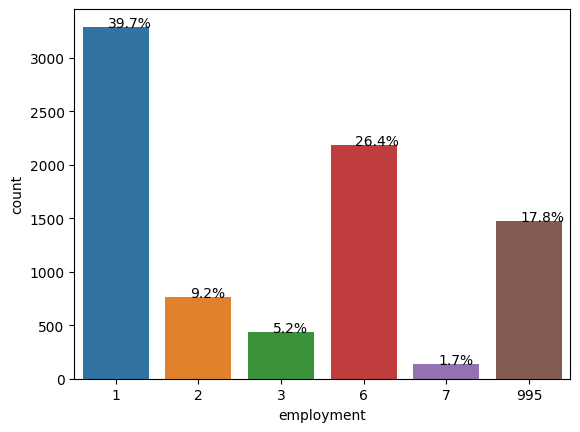

In [18]:
count_plot_percentage(data, 'employment')

* Most of the people are full-time paid employees
* Quarter of people aren't currently employed (e.g., retired, looking for work)
* Very few of people are volunteers or interns

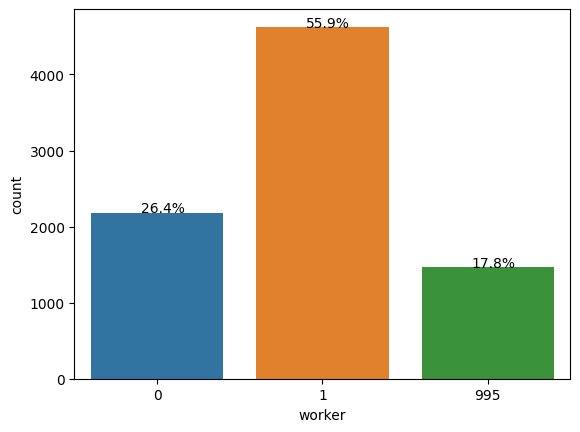

In [19]:
count_plot_percentage(data, 'worker')

* 55.9% of people are employed. Almost the half
* almost quarter of people aren't employed

In [20]:
data['jobs_count'].value_counts()

 995     5924
 1       2031
 2        231
 3         57
 6         17
-9998      15
 4          8
 5          3
Name: jobs_count, dtype: int64

In [21]:
data['job_type'].value_counts()

 995     5924
 1       1627
 2        497
 3        135
 4         88
-9998      15
Name: job_type, dtype: int64

Most usual work location for people is **one** work location, regardless of being a telework or onsite

In [22]:
data['industry'].value_counts().sort_values()

 3          3
 6         13
-9998      15
 11        28
 13        43
 2         60
 17        60
 5         87
 12        91
 9        100
 15       124
 10       128
 16       129
 14       167
 1        211
 4        221
 18       247
 7        298
 8        337
 995     5924
Name: industry, dtype: int64

* Most of them Missing: Skip logic
* Only 3 of them their work industry is: Capital goods (aerospace & defense, electrical, machinery)
* Most work industry in which people work in is: Health care/social assistance

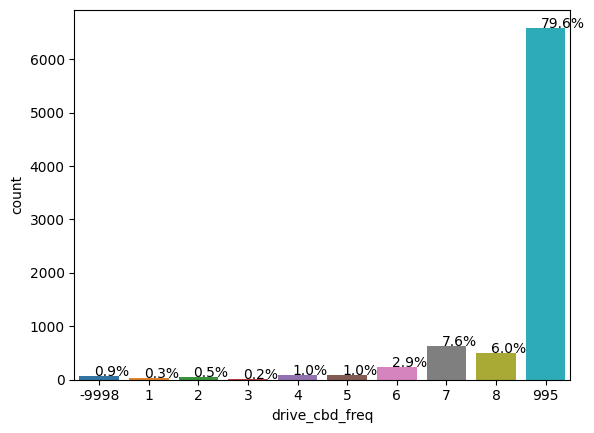

In [23]:
count_plot_percentage(data, 'drive_cbd_freq')

Regardless of 995(Missing: Skip logic), The majority of people who filled out the survey are those with least Frequency of driving vehicle into or within the area of Manhattan south of 60th Street

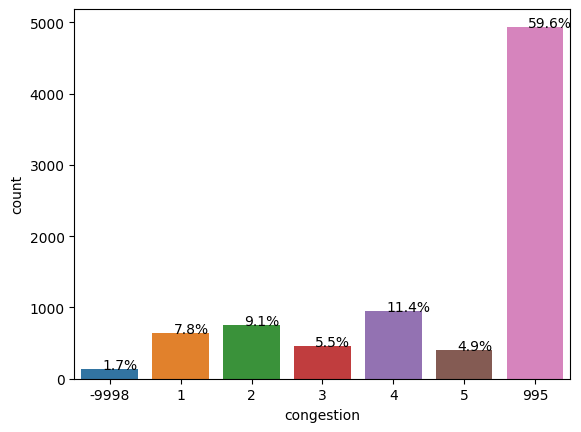

In [24]:
count_plot_percentage(data, 'congestion')

Proportion of people opposing and supporting the congistion almost equal

<AxesSubplot: xlabel='congestion', ylabel='count'>

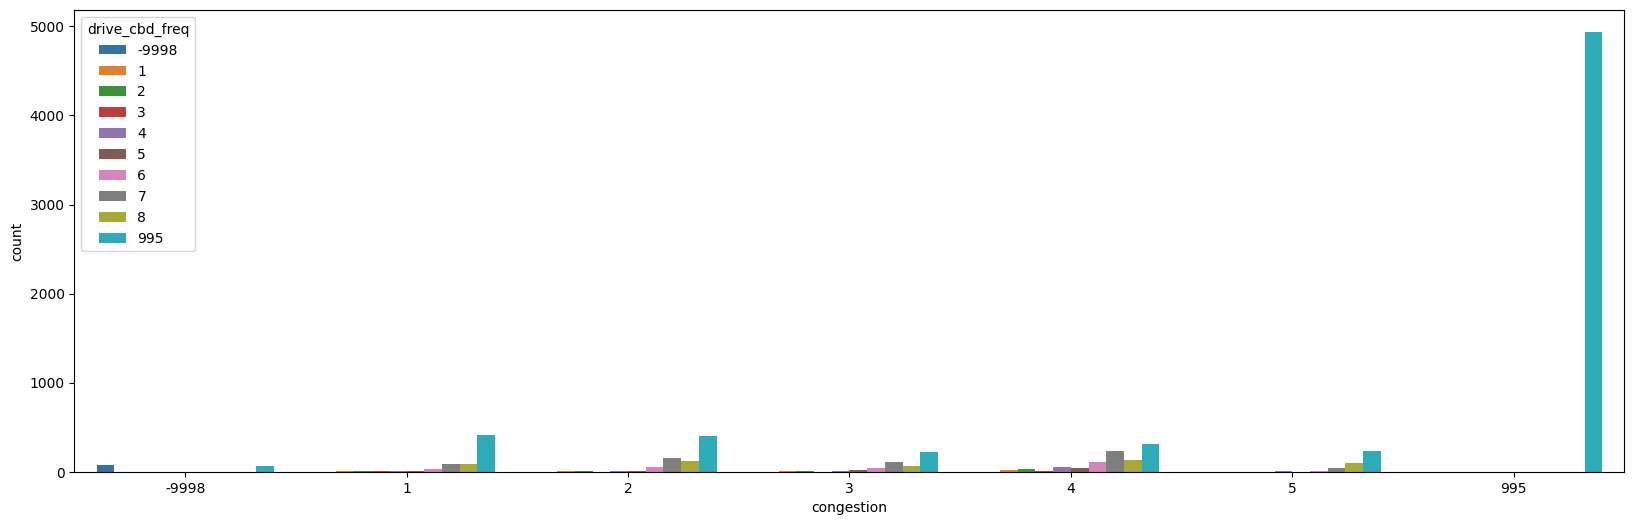

In [25]:
# Observe wheter people's frequency of driving vehicle into or within the area of Manhattan south of 60th Street affects supporting/opposing congesiton
plt.figure(figsize=(20, 6))
sns.countplot(x='congestion', hue='drive_cbd_freq', data=data)

No clear inferences, sounds that people who have never drived into or within Manhattan have alost equal voting with regard to congestion

In [26]:
data.groupby("congestion")["drive_cbd_freq"].value_counts()

congestion  drive_cbd_freq
-9998       -9998               73
             995                65
 1           995               413
             7                  87
             8                  86
             6                  30
             4                   8
             5                   8
             2                   7
             1                   3
             3                   3
 2           995               405
             7                 150
             8                 118
             6                  50
             5                  11
             4                  10
             2                   7
             1                   4
             3                   1
 3           995               218
             7                 107
             8                  61
             6                  37
             5                  19
             4                   9
             1                   3
             2              

Expect that people with more telework frequency support congestion and vice versa, let's detect that

<AxesSubplot: xlabel='telework_freq', ylabel='count'>

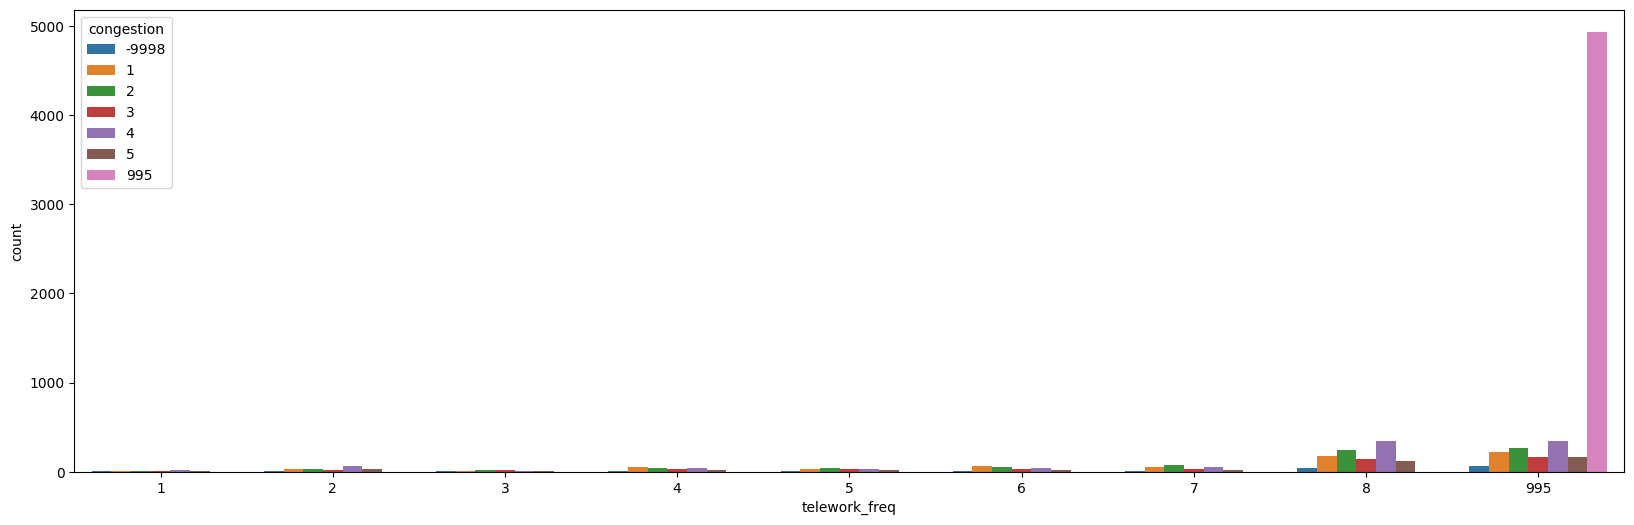

In [27]:
plt.figure(figsize=(20, 6))
sns.countplot(x='telework_freq', hue='congestion', data=data)

besides missing(skip logic), the majority voting is from people with no telework. Appear that most of them highly opposing congestion

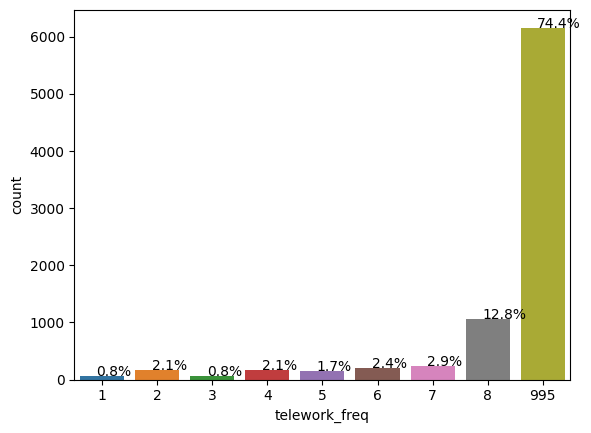

In [67]:
count_plot_percentage(data, 'telework_freq')

As detected from previous plot, majority of them are those with no telework, and missing(skip logic)

In [71]:
data['bike_num_days'].value_counts()

995    7007
0      1090
1        68
2        37
3        30
4        17
5        15
6        12
7        10
Name: bike_num_days, dtype: int64

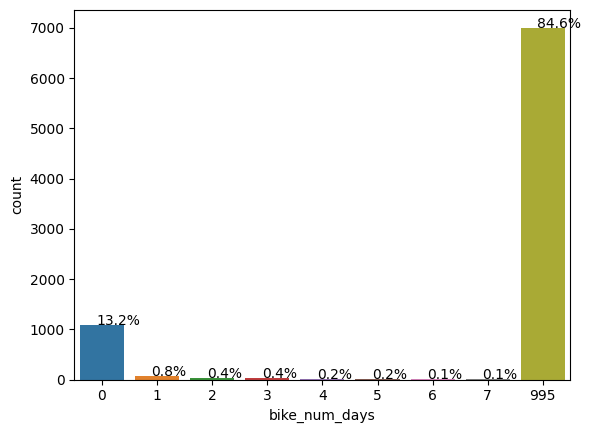

In [28]:
count_plot_percentage(data, 'bike_num_days')

Most of people don't ride a bike The whole week

<AxesSubplot: xlabel='bike_num_days', ylabel='count'>

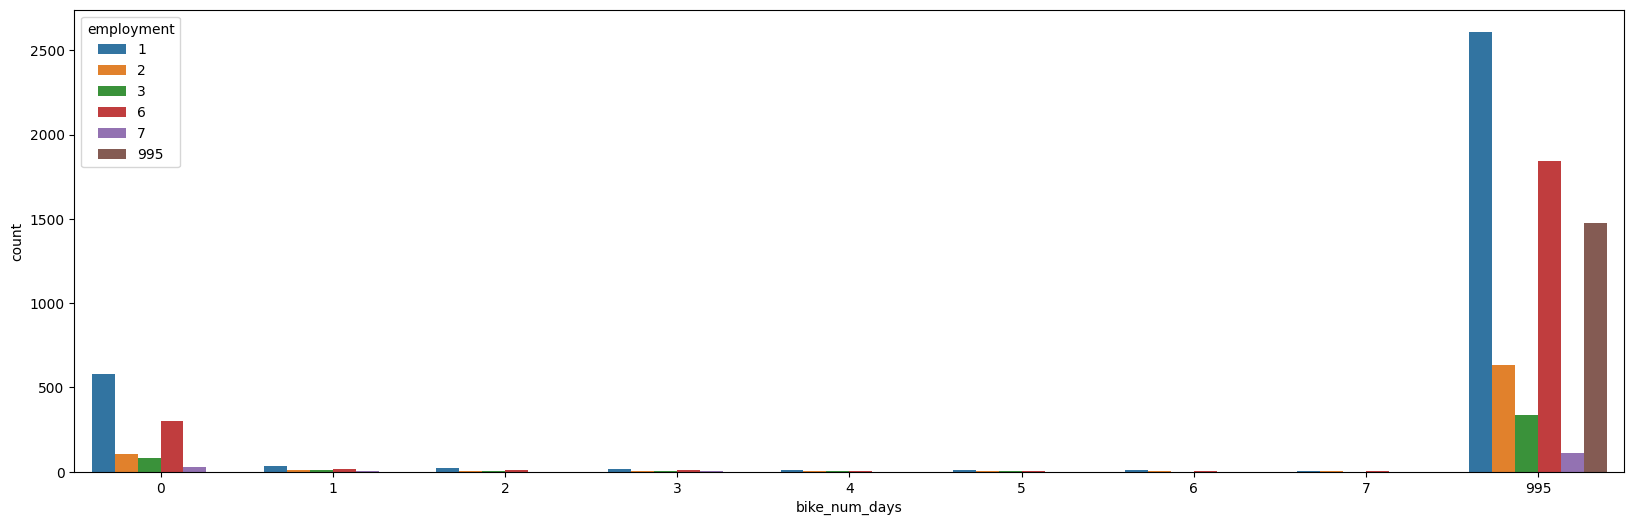

In [29]:
# Detect Bike && unemployed
plt.figure(figsize=(20, 6))
sns.countplot(x='bike_num_days', hue='employment', data=data)

In [ ]:
data = pd.read_csv("data.csv")

In [ ]:
trip_data = data[['hh_id','weight','cms_zone','survey_mode','person_id','person_num','is_participant','num_days','num_days_complete','num_trips','num_walk_trips','num_transit_trips','num_bike_trips','num_taxi_trips','num_tnc_trips','num_complete_weekend_days','num_complete_weekdays','first_travel_date','last_travel_date','made_trips','smartphone_type',
             'relationship','age','employment','worker']]

In [ ]:
# Check unique values for each feature
obj = trip_data.nunique()
for key,value in obj.iteritems():
    print(key,",",value)

hh_id , 3346
weight , 2497
cms_zone , 10
survey_mode , 3
person_id , 8286
person_num , 11
is_participant , 2
num_days , 2
num_days_complete , 7
num_trips , 109
num_walk_trips , 68
num_transit_trips , 45
num_bike_trips , 25
num_taxi_trips , 11
num_tnc_trips , 14
num_complete_weekend_days , 3
num_complete_weekdays , 6
first_travel_date , 39
last_travel_date , 40
made_trips , 2
smartphone_type , 5
relationship , 10
age , 11
employment , 6
worker , 3


In [ ]:
trip_data.dtypes

hh_id                          int64
weight                       float64
cms_zone                      object
survey_mode                    int64
person_id                      int64
person_num                     int64
is_participant                 int64
num_days                     float64
num_days_complete            float64
num_trips                    float64
num_walk_trips               float64
num_transit_trips            float64
num_bike_trips               float64
num_taxi_trips               float64
num_tnc_trips                float64
num_complete_weekend_days    float64
num_complete_weekdays        float64
first_travel_date             object
last_travel_date              object
made_trips                   float64
smartphone_type                int64
relationship                   int64
age                            int64
employment                     int64
worker                         int64
dtype: object

##### hh_id & person_id will be removed, it provides no extra information about the data
##### weight will be provided in the next iteration, we are keeping features in this iteration as simple as possible
##### first_travel_date and last_travel_date will be removed in this iteration, not clearly understandable yet
##### num_days and num_days_complete won't be included in this iteration, need more information about them

In [ ]:
data.drop(['hh_id','person_id','weight','first_travel_date','last_travel_date','num_days','num_days_complete'],axis=1, inplace=True)

##### only data when is_participant equals to 1 will be selected then drop the column, current information: not participant doesn't help in survey information, almost all data is null when is_participant equals to 0 

In [ ]:
data_when_is_participant_zero = trip_data[trip_data['is_participant'] == 0]

In [ ]:
# check sum of nulls 
obj = data_when_is_participant_zero.isnull().sum()
for key,value in obj.iteritems():
    print(key,",",value)

hh_id , 0
weight , 0
cms_zone , 0
survey_mode , 0
person_id , 0
person_num , 0
is_participant , 0
num_days , 4940
num_days_complete , 4940
num_trips , 4940
num_walk_trips , 4940
num_transit_trips , 4940
num_bike_trips , 4940
num_taxi_trips , 4940
num_tnc_trips , 4940
num_complete_weekend_days , 4940
num_complete_weekdays , 4940
first_travel_date , 0
last_travel_date , 0
made_trips , 4940
smartphone_type , 0
relationship , 0
age , 0
employment , 0
worker , 0


In [ ]:
# select data when value of is_participant = 1
trip_data = trip_data[trip_data['is_participant'] == 1]
data = data[data['is_participant'] == 1]

In [ ]:
obj = trip_data.nunique()
for key,value in obj.iteritems():
    print(key,",",value)

hh_id , 3346
weight , 2496
cms_zone , 10
survey_mode , 3
person_id , 3346
person_num , 1
is_participant , 1
num_days , 2
num_days_complete , 7
num_trips , 109
num_walk_trips , 68
num_transit_trips , 45
num_bike_trips , 25
num_taxi_trips , 11
num_tnc_trips , 14
num_complete_weekend_days , 3
num_complete_weekdays , 6
first_travel_date , 39
last_travel_date , 40
made_trips , 2
smartphone_type , 4
relationship , 1
age , 8
employment , 5
worker , 2


##### as a result person_num and relationship feature will be deleted because they have on value

In [ ]:
data.drop(['person_num','relationship'],axis=1)

,cms_zone,survey_mode,is_participant,num_trips,num_walk_trips,num_transit_trips,num_bike_trips,num_taxi_trips,num_tnc_trips,num_complete_weekend_days,...,race_native_hawaiian,race_white,race_other,disability_hearing,disability_seeing,disability_walking,disability_mobility,disability_dressing,disability_concentrating,disability_none
2,Inner Brooklyn,1,1,23.0,1.0,3.0,11.0,0.0,0.0,2.0,...,1,0,0,0,0,0,0,0,0,1
5,Middle Queens,1,1,15.0,2.0,1.0,0.0,0.0,0.0,2.0,...,0,0,0,0,0,0,0,0,0,1
6,Middle Queens,1,1,30.0,22.0,9.0,0.0,0.0,0.0,2.0,...,0,1,0,0,0,0,0,0,0,1
10,Middle Queens,1,1,48.0,23.0,13.0,0.0,0.0,0.0,2.0,...,0,0,0,0,0,0,0,0,0,1
12,Middle Queens,1,1,45.0,13.0,6.0,12.0,0.0,2.0,2.0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8270,Staten Island,2,1,2.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
8273,Staten Island,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
8274,Staten Island,2,1,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
8278,Staten Island,2,1,4.0,0.0,2.0,0.0,0.0,1.0,1.0,...,0,1,0,0,0,0,0,0,0,1


In [ ]:
trips_numerical_data = data[['num_trips','num_walk_trips','num_transit_trips','num_bike_trips','num_taxi_trips','num_tnc_trips','num_complete_weekend_days',
                      'num_complete_weekdays']]

In [ ]:
trips_numerical_data.describe()

,num_trips,num_walk_trips,num_transit_trips,num_bike_trips,num_taxi_trips,num_tnc_trips,num_complete_weekend_days,num_complete_weekdays
count,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000
mean,25.540646,10.004782,5.827555,0.419307,0.111775,0.374776,1.266886,3.067244
std,21.900434,12.091553,7.646751,2.141812,1.664201,1.181070,0.843984,1.858192
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,24.000000,5.000000,2.000000,0.000000,0.000000,0.000000,2.000000,4.000000
75%,41.000000,16.000000,10.000000,0.000000,0.000000,0.000000,2.000000,5.000000
max,178.000000,93.000000,57.000000,36.000000,92.000000,18.000000,2.000000,5.000000


##### from the frequency matrix -columns features, rows values- 
##### for example count of 1 of survey_mode is the most frequent which means people filled the survey by using rMove (smartphone app)
##### Northern Bronx is the most frequent cms_zone
##### Age values are between 5 and 11, which means 18yo and older
##### most answers from people has iphone mobile 

In [ ]:
# display correlation matrix between features
numeric_corr_matrix = trips_numerical_data.corr()
numeric_corr_matrix

,num_trips,num_walk_trips,num_transit_trips,num_bike_trips,num_taxi_trips,num_tnc_trips,num_complete_weekend_days,num_complete_weekdays
num_trips,1.000000,0.685732,0.574478,0.162543,0.081621,0.187826,0.494895,0.530072
num_walk_trips,0.685732,1.000000,0.610044,0.116651,0.021248,0.183317,0.428865,0.468685
num_transit_trips,0.574478,0.610044,1.000000,0.009034,0.015657,0.135196,0.346632,0.380096
num_bike_trips,0.162543,0.116651,0.009034,1.000000,0.007480,0.062776,0.090722,0.105136
num_taxi_trips,0.081621,0.021248,0.015657,0.007480,1.000000,0.033284,0.036010,0.036915
num_tnc_trips,0.187826,0.183317,0.135196,0.062776,0.033284,1.000000,0.155752,0.166960
num_complete_weekend_days,0.494895,0.428865,0.346632,0.090722,0.036010,0.155752,1.000000,0.703968
num_complete_weekdays,0.530072,0.468685,0.380096,0.105136,0.036915,0.166960,0.703968,1.000000


##### NaN = no correlation between, they don't affect/change each other, propably going to be deleted --person_num--
##### regardless the change of person_num, num of trips kinds don't change

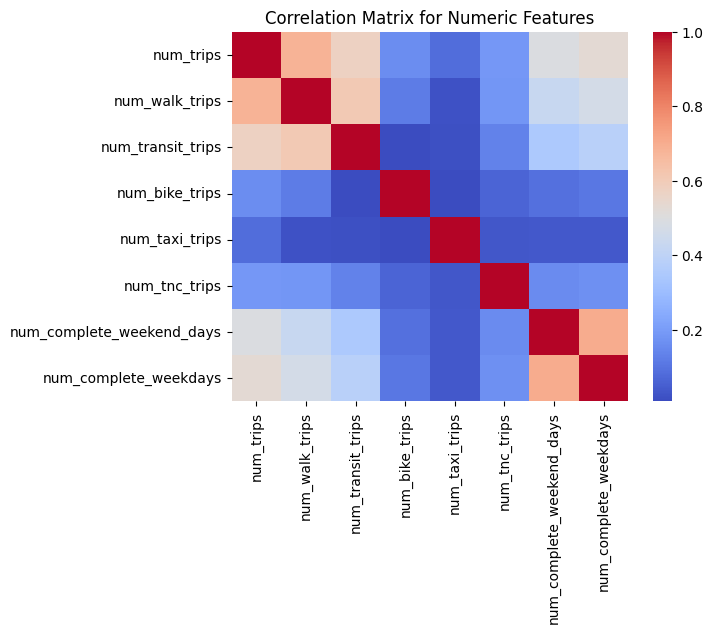

In [ ]:
# Plot a correlation matrix for numeric features
sns.heatmap(numeric_corr_matrix, cmap='coolwarm')
plt.title('Correlation Matrix for Numeric Features')
plt.show()

In [ ]:
categorical_data = data[['made_trips','smartphone_type','relationship','age','cms_zone','survey_mode']]

In [ ]:
categorical_data['age'].unique()

array([ 5,  7,  6,  4,  9,  8, 10, 11], dtype=int64)

In [ ]:
# dropping age 1 (under 5) // data may be innaccurate
data.drop(data[data['age'] == 1].index, inplace=True)

##### See Frequency/Count for each value of the categorical features

In [ ]:
categorical_frequency = categorical_data.apply(pd.Series.value_counts)
categorical_frequency

,made_trips,smartphone_type,relationship,age,cms_zone,survey_mode
0.0,309.0,377.0,3346.0,NaN,NaN,NaN
1.0,3037.0,1206.0,NaN,NaN,NaN,2496.0
2.0,NaN,1747.0,NaN,NaN,NaN,689.0
3.0,NaN,16.0,NaN,NaN,NaN,161.0
4.0,NaN,NaN,NaN,253.0,NaN,NaN
5.0,NaN,NaN,NaN,749.0,NaN,NaN
6.0,NaN,NaN,NaN,664.0,NaN,NaN
7.0,NaN,NaN,NaN,612.0,NaN,NaN
8.0,NaN,NaN,NaN,555.0,NaN,NaN
9.0,NaN,NaN,NaN,361.0,NaN,NaN


<AxesSubplot: >

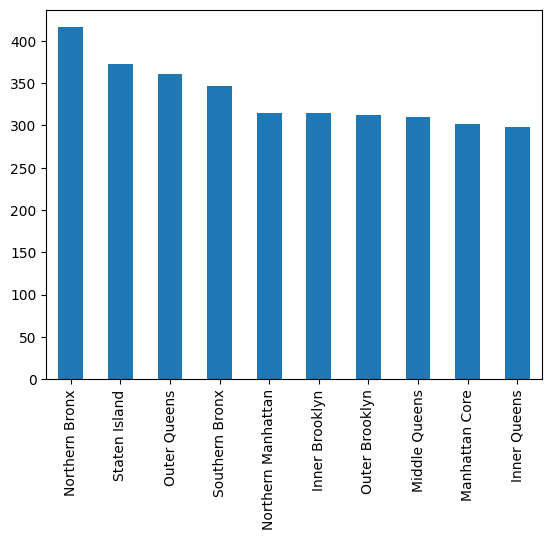

In [ ]:
categorical_data['cms_zone'].value_counts().plot(kind='bar')

In [ ]:
school_numerical_data = data[['school_park_amount_day','school_park_amount_week','school_park_amount_month','school_park_amount_year']]

In [ ]:
school_categorical_data = data[['student','license','vehicle','congestion','school_type','school_cms_zone',
                                       'missing_school_location','kid_accompany','school_mode','school_mode_own','school_park_location',
                                       'school_vehicle_pass_period', 'school_mode_auto', 'school_mode_bus','school_mode_rail', 'school_mode_ferry', 'school_access',
                                       'school_egress', 'school_mode_taxi', 'school_mode_bike','school_bike_park', 'school_mode_scooter', 'school_scooter_park']]

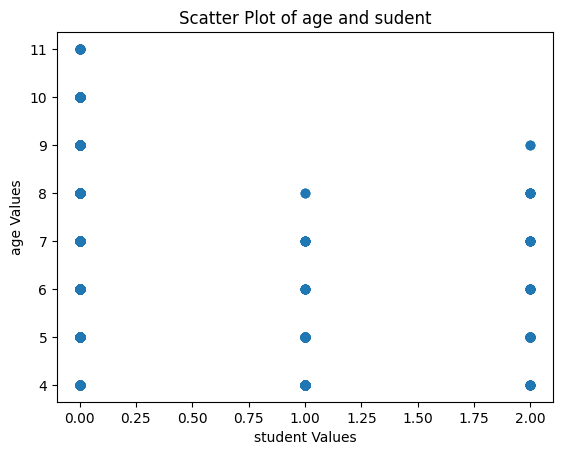

In [ ]:
# Plot a scatter plot of two features
plt.scatter(data['student'], data['age'])
plt.title('Scatter Plot of age and sudent')
plt.xlabel('student Values')
plt.ylabel('age Values')
plt.show()

In [ ]:
data[data['student'] == 1]['age'].unique()

array([5, 6, 4, 7, 8], dtype=int64)

In [ ]:
data.loc[data['student'] == 1]['age'].unique()

array([5, 6, 4, 7, 8], dtype=int64)

#### from the plot
##### not students age varies between 4(18-24) and 11(85 or older)
##### full time student age varies between 1(Under 5) //dropped and 10(75-84)
##### half-time student age varies between 4(18-24) and 9(65-74)

<AxesSubplot: >

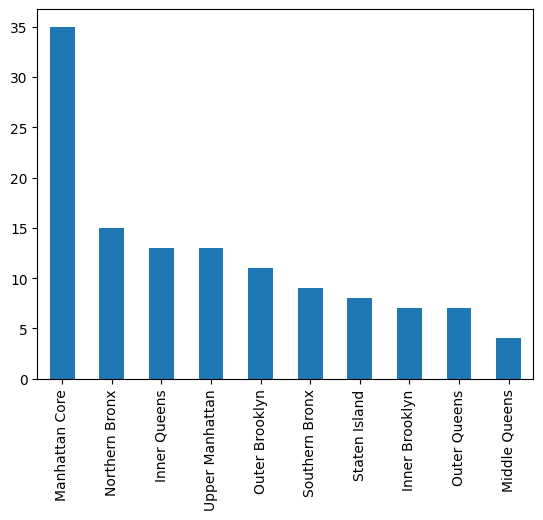

In [ ]:
school_categorical_data['school_cms_zone'].value_counts().plot(kind='bar')

##### Manhattan Core has the highest number of school

<AxesSubplot: >

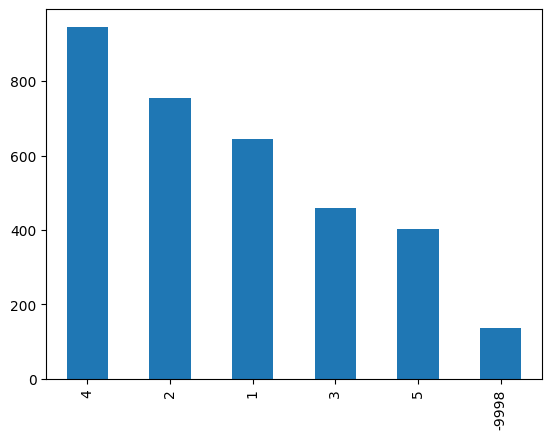

In [ ]:
school_categorical_data['congestion'].value_counts().plot(kind='bar')

##### high number of people don't agree with the policy of congestion pricing (4)

In [ ]:
school_numerical_data.describe()

,school_park_amount_day,school_park_amount_week,school_park_amount_month,school_park_amount_year
count,6.000000,4.000000,7.000000,7.000000
mean,9.166667,26.250000,27.142857,146.428571
std,5.671567,29.669007,20.268437,165.079634
min,2.000000,4.000000,4.000000,4.000000
25%,5.000000,12.250000,15.500000,15.500000
50%,9.000000,15.500000,20.000000,90.000000
75%,13.750000,29.500000,37.500000,225.000000
max,16.000000,70.000000,60.000000,450.000000


In [ ]:
# display correlation matrix between features
numeric_corr_matrix = school_numerical_data.corr()
numeric_corr_matrix

,school_park_amount_day,school_park_amount_week,school_park_amount_month,school_park_amount_year
school_park_amount_day,1.0,1.0,1.0,1.0
school_park_amount_week,1.0,1.0,1.0,1.0
school_park_amount_month,1.0,1.0,1.0,1.0
school_park_amount_year,1.0,1.0,1.0,1.0


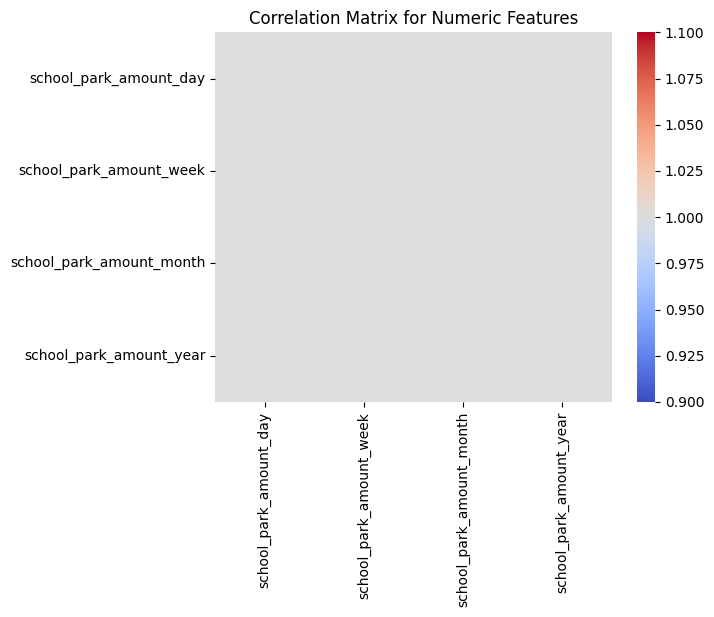

In [ ]:
# Plot a correlation matrix for numeric features
sns.heatmap(numeric_corr_matrix, cmap='coolwarm')
plt.title('Correlation Matrix for Numeric Features')
plt.show()

##### Strong Correlated

In [ ]:
harassment_data = data[['harassment','harassment_private_car', 'harassment_alone', 'harassment_attention',
       'harassment_defense', 'harassment_other', 'harassment_none', 'gender',
       'education', 'english_proficiency', 'ethnicity', 'race_american_indian',
       'race_asian', 'race_black', 'race_native_hawaiian', 'race_white',
       'race_other', 'disability_hearing', 'disability_seeing',
       'disability_walking', 'disability_mobility', 'disability_dressing',
       'disability_concentrating', 'disability_none']]

<AxesSubplot: >

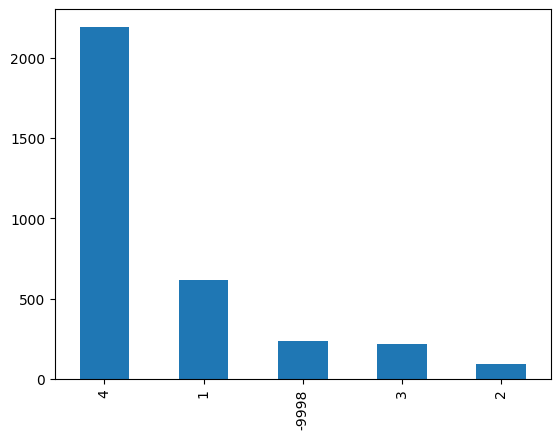

In [ ]:
harassment_data['harassment'].value_counts().plot(kind='bar')

##### most haven't seen or experienced harassment (4)

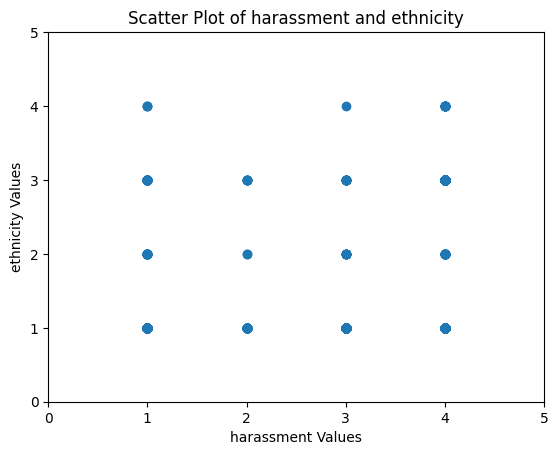

In [ ]:
# Plot a scatter plot of two features
plt.scatter(harassment_data['harassment'], harassment_data['ethnicity'])
plt.title('Scatter Plot of harassment and ethnicity')
plt.xlabel('harassment Values')
plt.ylabel('ethnicity Values')
plt.ylim(0,5)
plt.xlim(0,5)
plt.show()

##### all have seen and/or experienced harassment, and mexican people seem to experience it the most

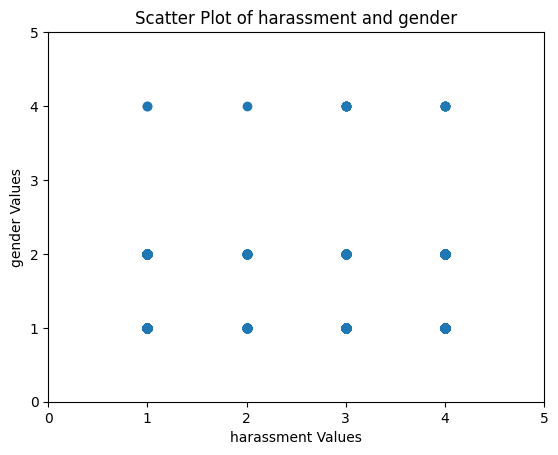

In [ ]:
plt.scatter(harassment_data['harassment'], harassment_data['gender'])
plt.title('Scatter Plot of harassment and gender')
plt.xlabel('harassment Values')
plt.ylabel('gender Values')
plt.ylim(0,5)
plt.xlim(0,5)
plt.show()

##### all genders are equal

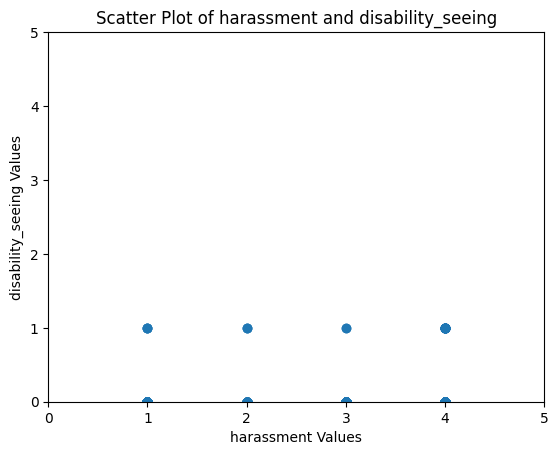

In [ ]:
plt.scatter(harassment_data['harassment'], harassment_data['disability_seeing'])
plt.title('Scatter Plot of harassment and disability_seeing')
plt.xlabel('harassment Values')
plt.ylabel('disability_seeing Values')
plt.ylim(0,5)
plt.xlim(0,5)
plt.show()

##### disabilities doesn't really affect

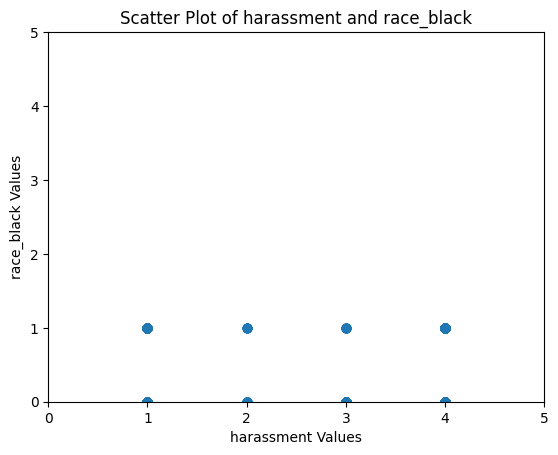

In [ ]:
plt.scatter(harassment_data['harassment'], harassment_data['race_black'])
plt.title('Scatter Plot of harassment and race_black')
plt.xlabel('harassment Values')
plt.ylabel('race_black Values')
plt.ylim(0,5)
plt.xlim(0,5)
plt.show()

##### black or other doesn't affect

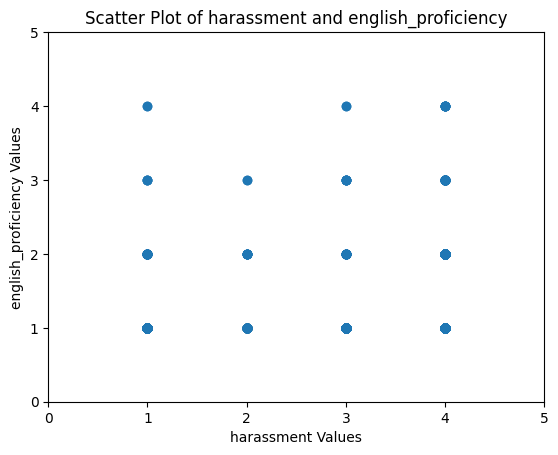

In [ ]:
plt.scatter(harassment_data['harassment'], harassment_data['english_proficiency'])
plt.title('Scatter Plot of harassment and english_proficiency')
plt.xlabel('harassment Values')
plt.ylabel('english_proficiency Values')
plt.ylim(0,5)
plt.xlim(0,5)
plt.show()

##### who speaks english well got harassment

In [ ]:
package_data = data[['packages','packages_distance']]

In [ ]:
package_frequency = package_data.apply(pd.Series.value_counts)
package_frequency

,packages,packages_distance
-9998,234.0,NaN
1,696.0,44.0
2,1283.0,98.0
3,312.0,161.0
4,163.0,93.0
5,152.0,29.0
6,150.0,40.0
7,163.0,NaN
8,193.0,NaN
995,NaN,2881.0


<AxesSubplot: >

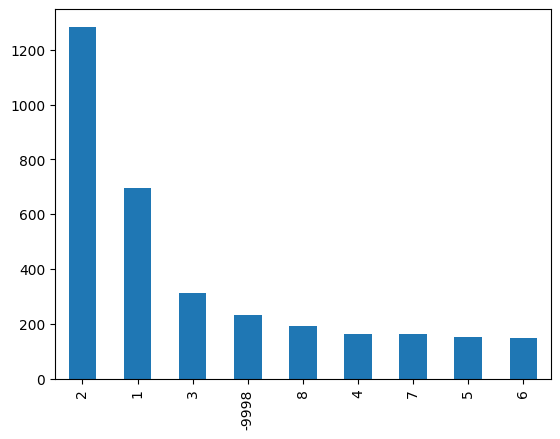

In [ ]:
package_data['packages'].value_counts().plot(kind='bar')

#### most people recieve their packages at their doorsteps

<AxesSubplot: >

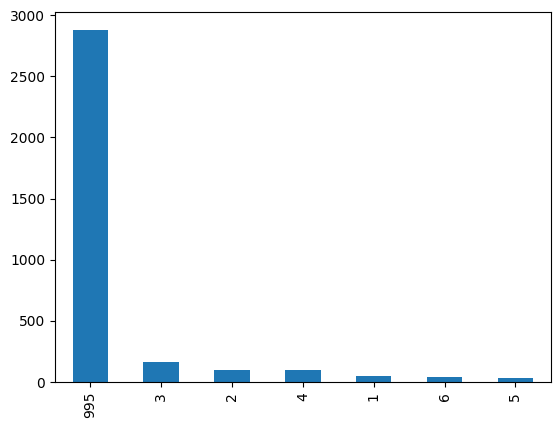

In [ ]:
package_data['packages_distance'].value_counts().plot(kind='bar')

#### most people move 3 blocks away ((around neighbourhood)) to get their packages 
###### 1 block = 15 meters

In [ ]:
numerical_data= pd.concat([trips_numerical_data,school_numerical_data],axis=1)

In [ ]:
numerical_data['school_park_amount_year'].unique()

array([ nan,  90., 450., 250., 200.,   4.,  16.,  15.])

C:\Users\danar\AppData\Local\Temp\ipykernel_13968\2273597600.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], ax=ax)


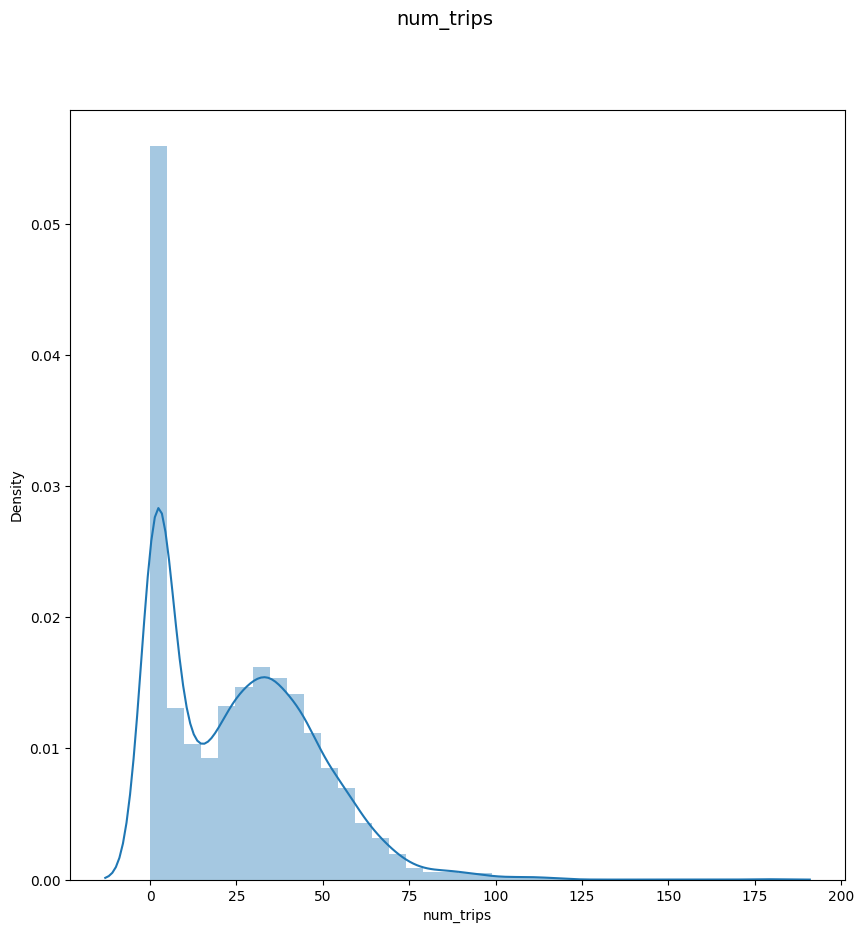

C:\Users\danar\AppData\Local\Temp\ipykernel_13968\2273597600.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], ax=ax)


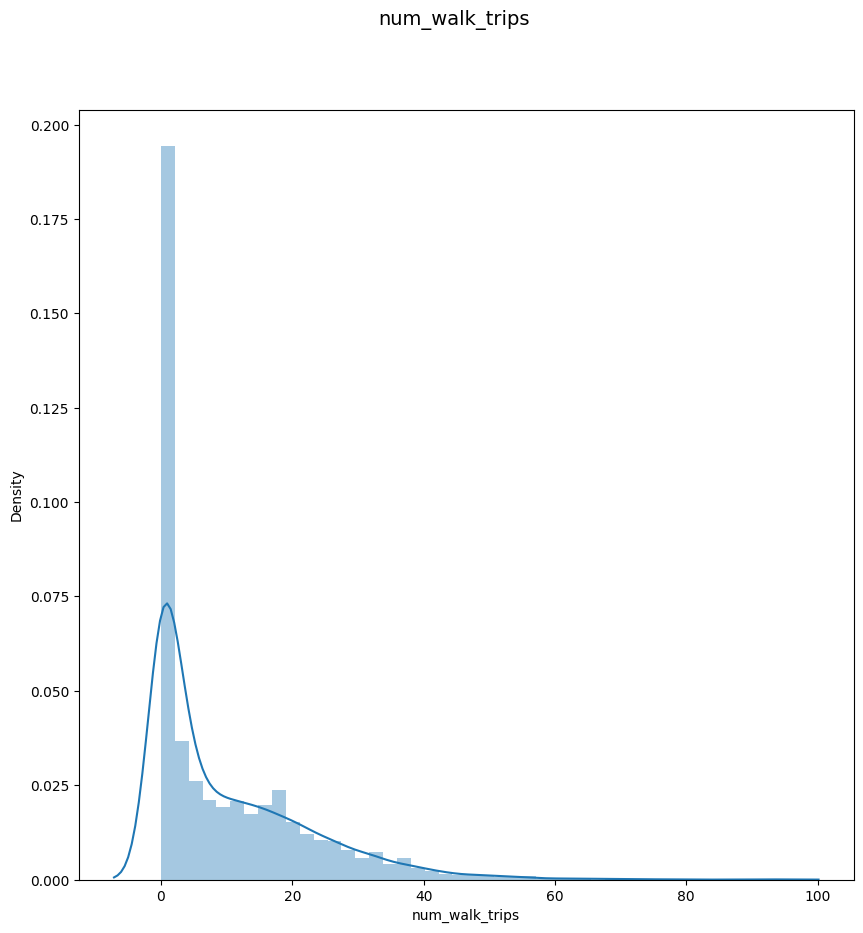

C:\Users\danar\AppData\Local\Temp\ipykernel_13968\2273597600.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], ax=ax)


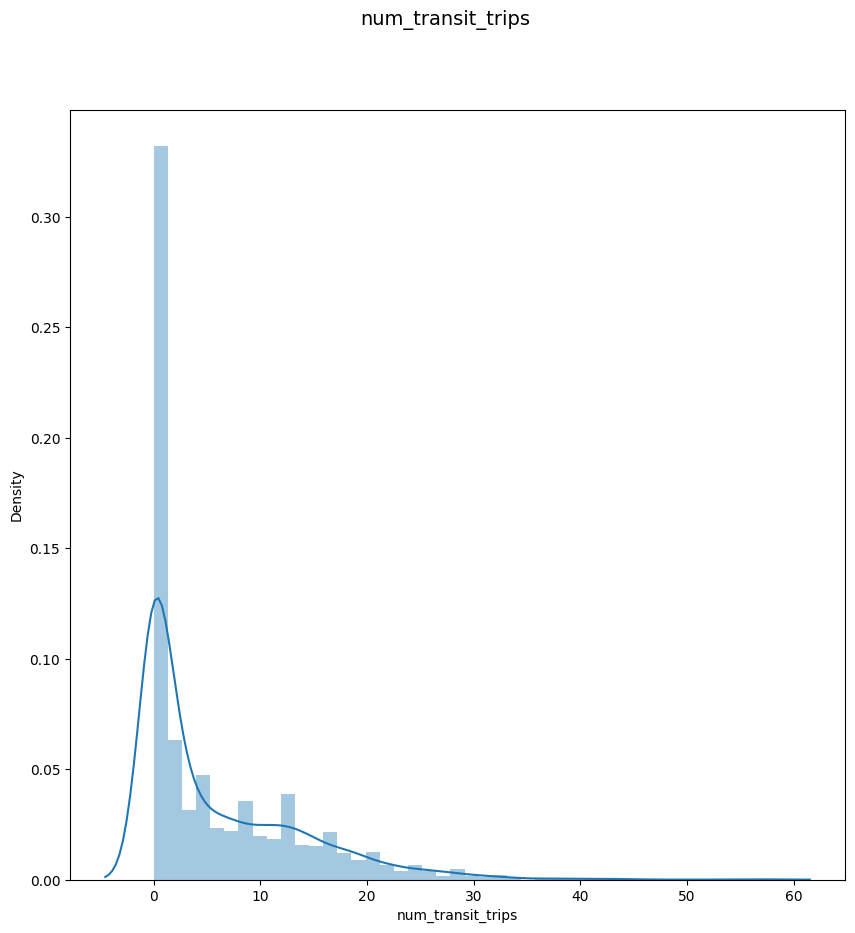

C:\Users\danar\AppData\Local\Temp\ipykernel_13968\2273597600.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], ax=ax)


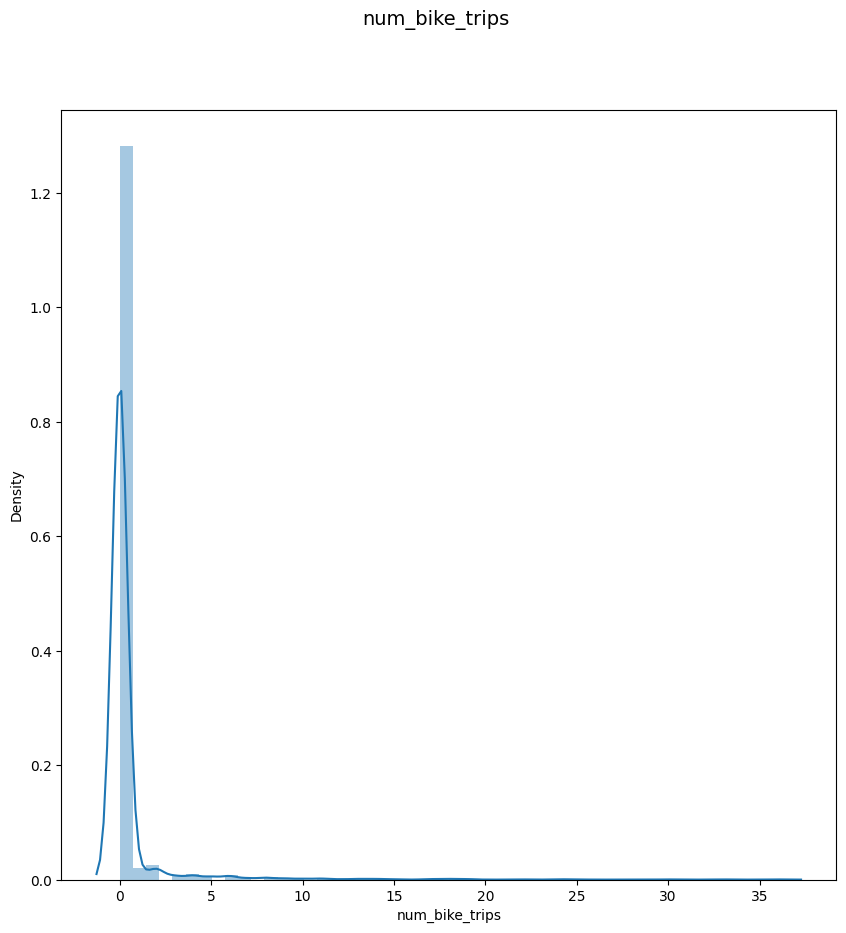

C:\Users\danar\AppData\Local\Temp\ipykernel_13968\2273597600.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], ax=ax)


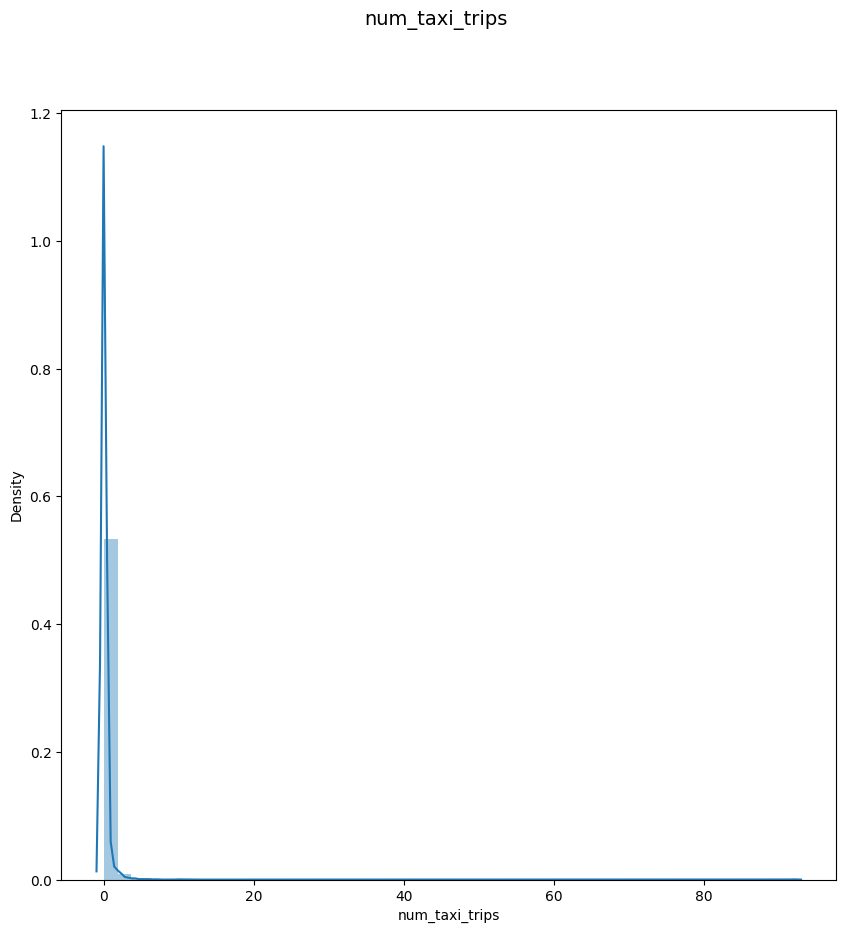

C:\Users\danar\AppData\Local\Temp\ipykernel_13968\2273597600.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], ax=ax)


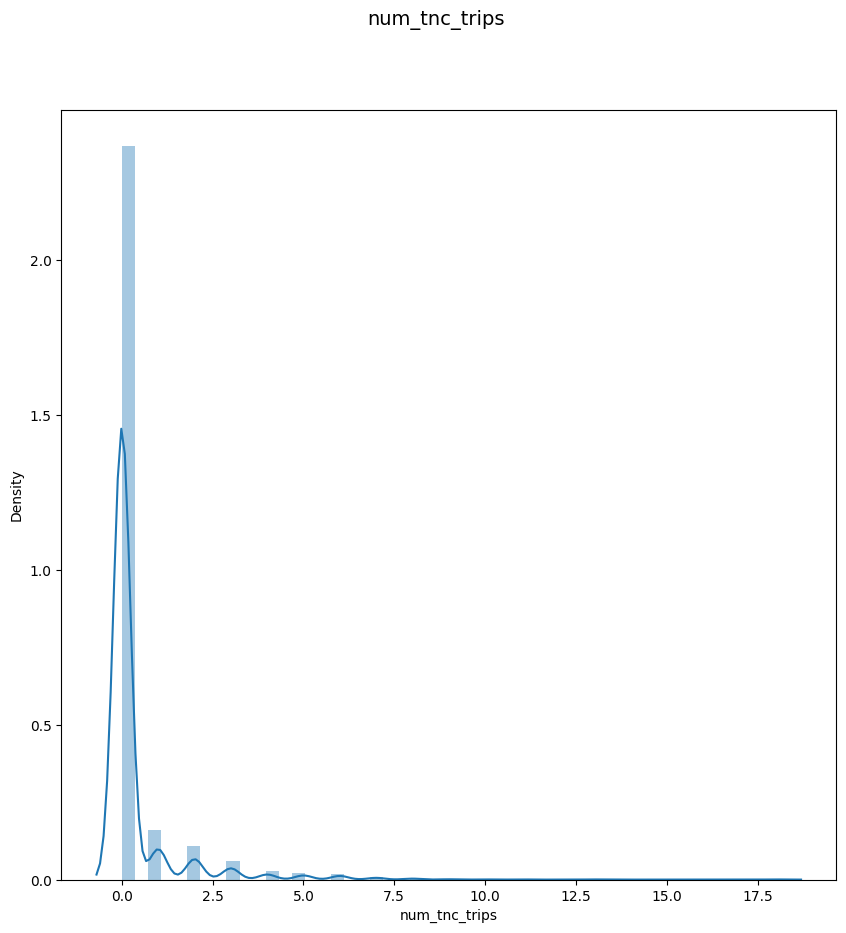

C:\Users\danar\AppData\Local\Temp\ipykernel_13968\2273597600.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], ax=ax)


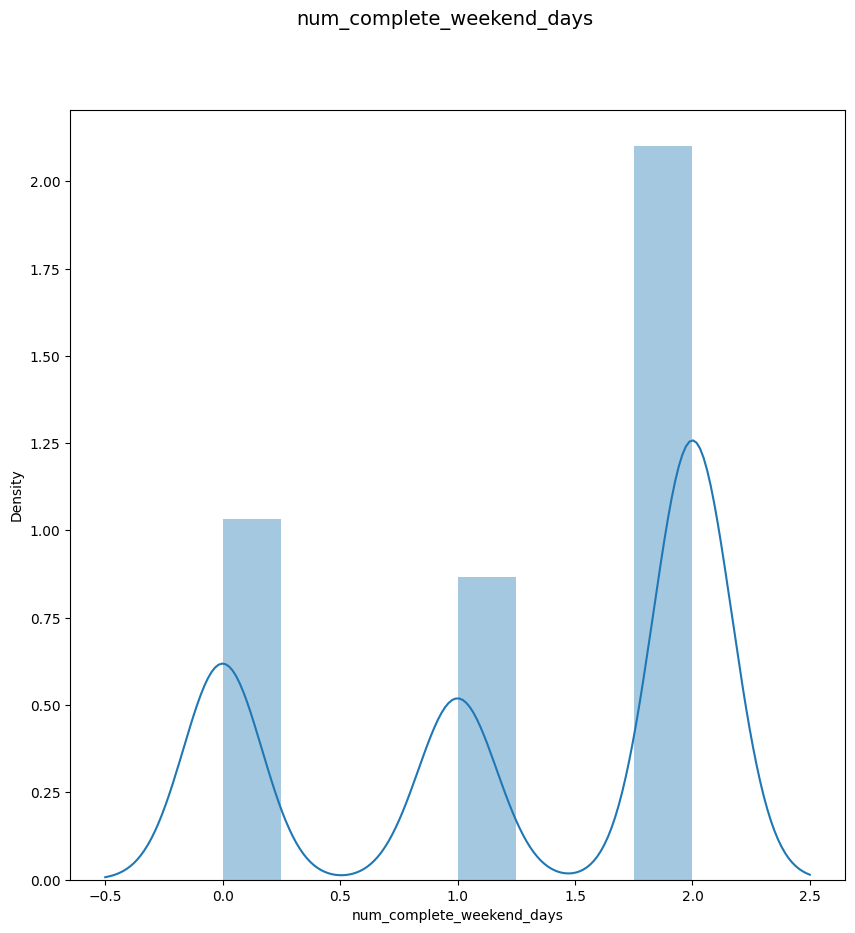

C:\Users\danar\AppData\Local\Temp\ipykernel_13968\2273597600.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], ax=ax)


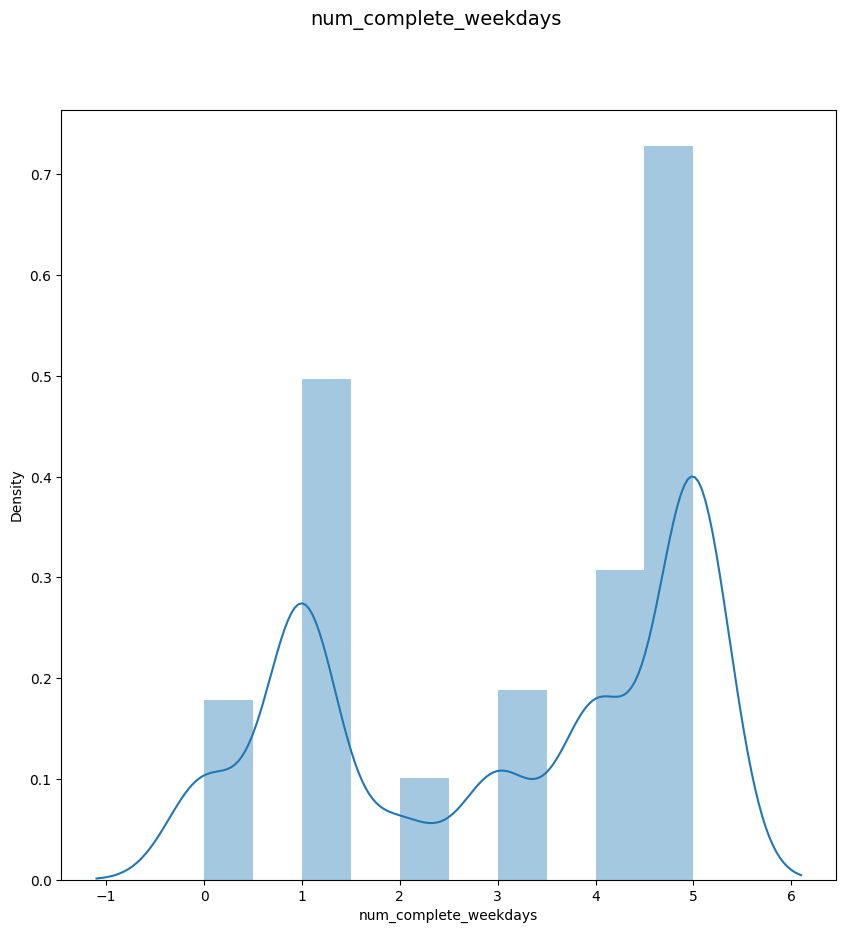

C:\Users\danar\AppData\Local\Temp\ipykernel_13968\2273597600.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], ax=ax)


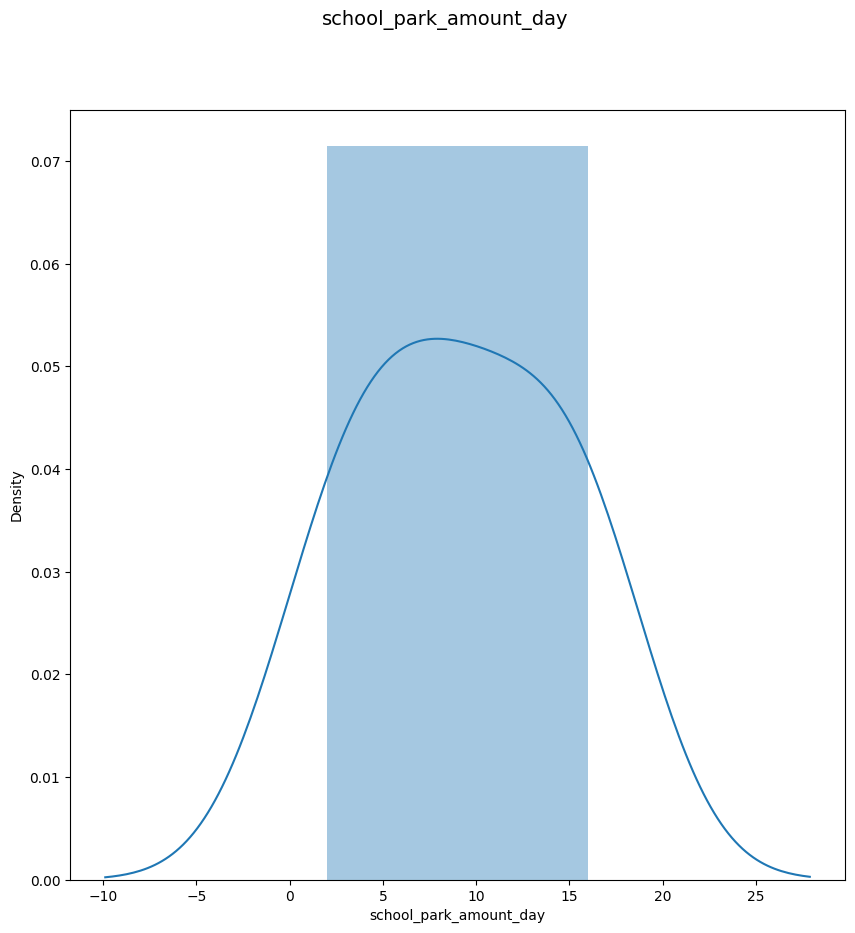

C:\Users\danar\AppData\Local\Temp\ipykernel_13968\2273597600.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], ax=ax)


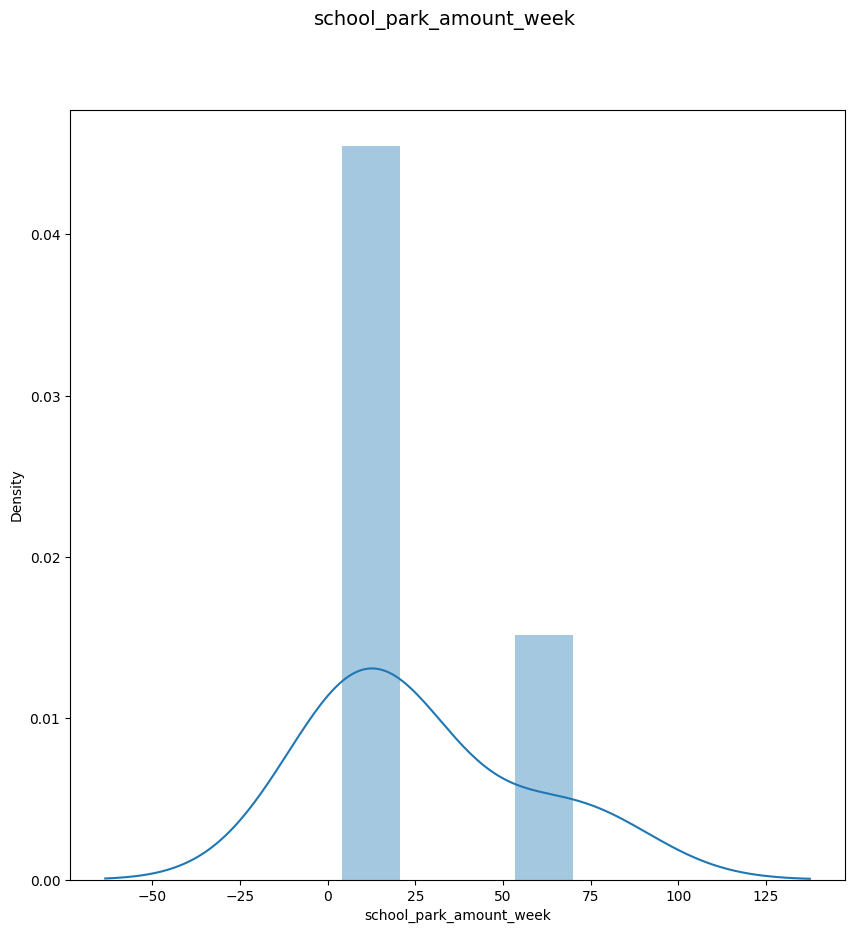

C:\Users\danar\AppData\Local\Temp\ipykernel_13968\2273597600.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], ax=ax)


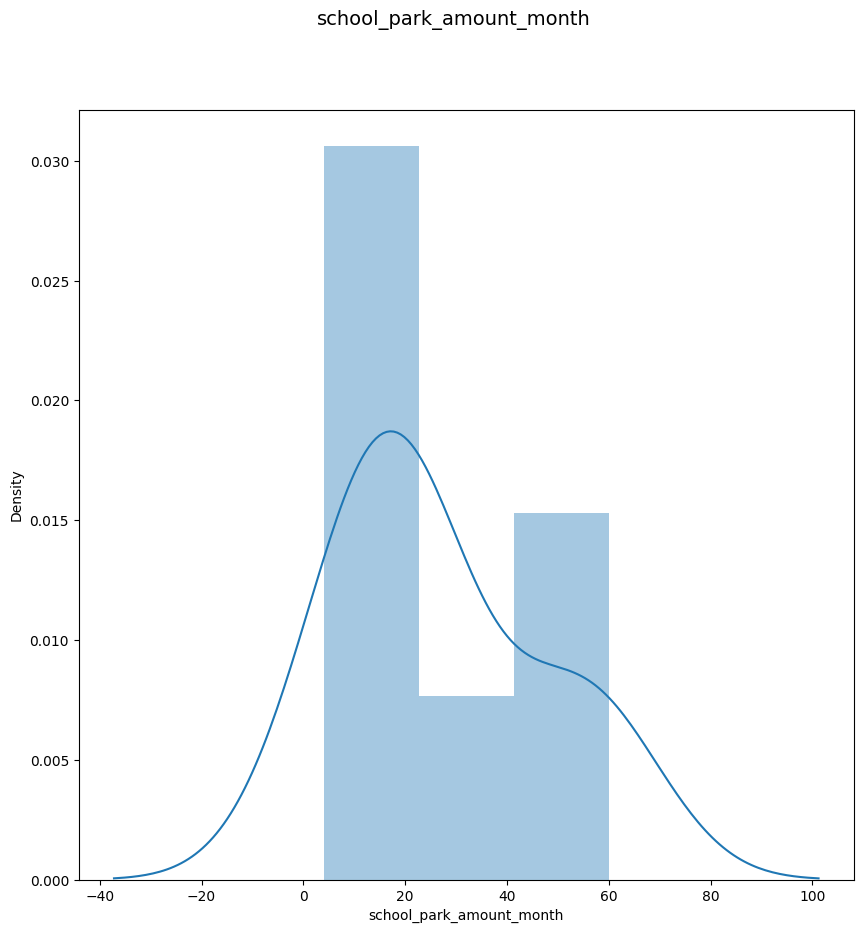

C:\Users\danar\AppData\Local\Temp\ipykernel_13968\2273597600.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], ax=ax)


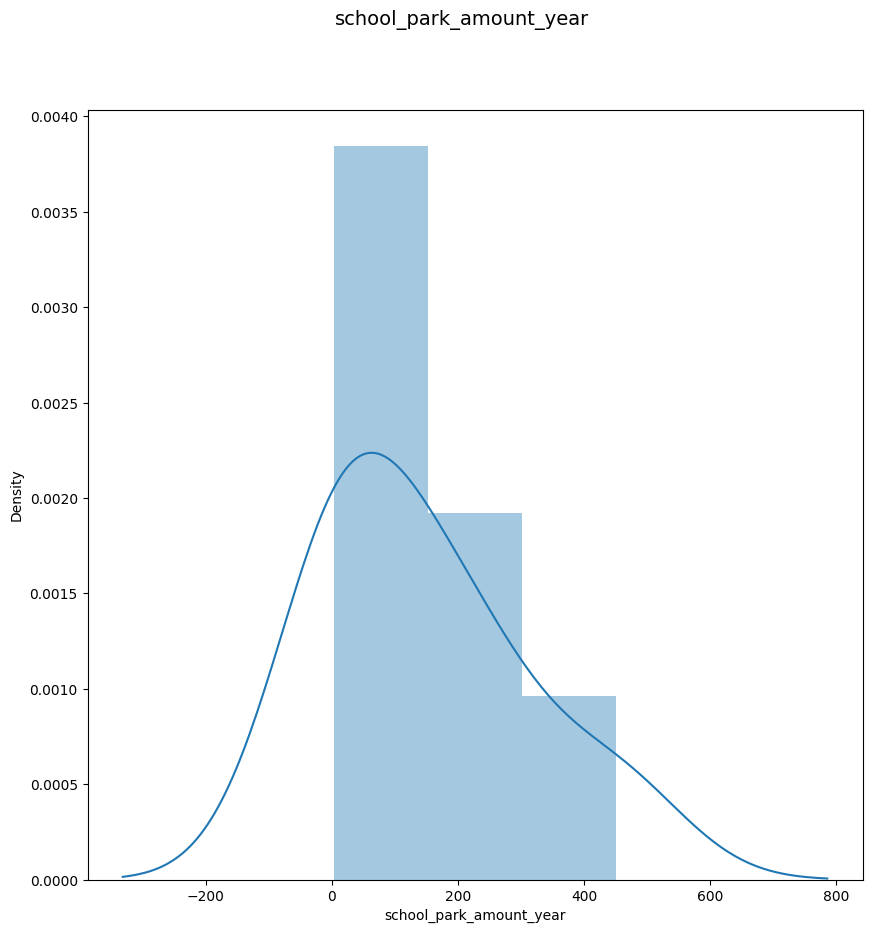

In [ ]:
def plots_(data,feature): 
        fig, ax = plt.subplots(1, figsize=(10,10), sharey=True)
        fig.suptitle(feature, fontsize=14)
        sns.distplot(data[feature], ax=ax)
        plt.show()

for column in numerical_data:
    feature=plots_(numerical_data, column)

# Missing Values

convert the -9998 value to NaN to handle it also with missing values

In [ ]:
for column in data.columns:
    data[column] = data[column].replace(-9998,np.nan)
    data[column] = data[column].replace("-9998",np.nan)

compute the percentage of null values of each column

In [ ]:
null_percentage = data.isna().sum().apply(lambda x:x/data.shape[0]*100).sort_values(ascending=False)[data.isna().sum()>0] 

<AxesSubplot: >

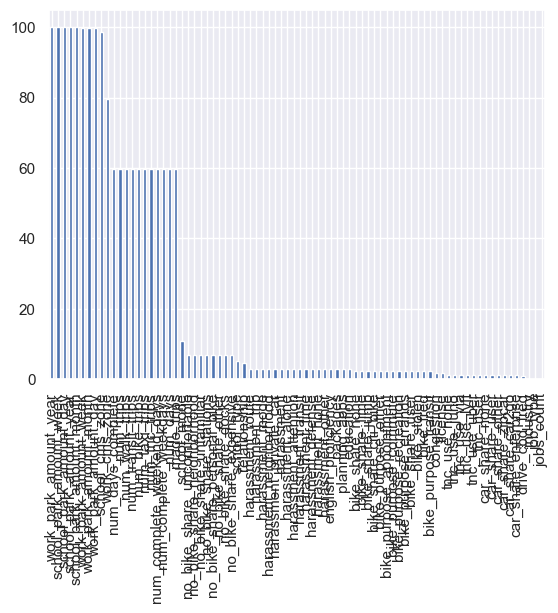

In [ ]:
null_percentage.plot(kind='bar')

remove any column have more than 50% NULL

In [ ]:
print(f"before Remove  {data.shape}")
data.drop(columns=null_percentage[null_percentage>50].index.to_list(),inplace=True)
print(f"after Remove  {data.shape}")


before Remove  (8286, 165)
after Remove  (8286, 144)


for the rest we will remove any row have null value

In [ ]:
print(f"before Remove  {data.shape}")
data = data.dropna(axis=0)
print(f"after Remove  {data.shape}")

before Remove  (8286, 144)
after Remove  (6504, 144)


remove any row have is_participant value not 1 becouse all the rest of the values are null

In [ ]:
print(f"before Remove  {data.shape}")
data = data[data["is_participant"]==1]
print(f"after Remove  {data.shape}")

before Remove  (6504, 144)
after Remove  (2692, 144)


In [ ]:
data.drop(["hh_id","person_id","relationship","is_participant"],axis=1,inplace=True)

# Encoding Features

In [ ]:
with open("data/columns_encoding.json") as file:
    columns_dictionary = json.loads(file.read()) # read the file as string and convert it to dictionary

In [ ]:
columns_dictionary

{'survey_mode': {'1': 'rMove',
  '2': 'rSurvey',
  '3': 'Call center',
  '995': 'skip logic'},
 'is_participant': {'0': 'Not selected', '1': 'Selected', '995': 'skip logic'},
 'made_trips': {'0': 'Not selected', '1': 'Selected', '995': 'skip logic'},
 'relationship': {'0': 'Self',
  '1': 'Spouse or partner',
  '2': 'Son or daughter',
  '3': 'Father or mother',
  '4': 'Brother or sister',
  '5': 'Other relative',
  '6': 'Roommate or friend',
  '7': 'Household help',
  '995': 'skip logic'},
 'age': {'1': 'Under 5',
  '2': '5-15',
  '3': '16-17',
  '4': '18-24',
  '5': '25-34',
  '6': '35-44',
  '7': '45-54',
  '8': '55-64',
  '9': '65-74',
  '10': '75-84',
  '11': '85 or older',
  '995': 'skip logic'},
 'employment': {'1': 'Employed full-time',
  '2': 'Employed part-time',
  '3': 'Primarily self-employed',
  '6': 'Not currently employed',
  '7': 'Unpaid volunteer or intern',
  '995': 'skip logic'},
 'worker': {'0': 'Not employed', '1': 'Employed', '995': 'skip logic'},
 'student': {'0': 

for each column_name in the dictionary encode the data using the dictionary values to create one_hot_encoding

In [ ]:
for column_name in columns_dictionary:
    data = one_hot_encoding(data=data,column=column_name,dictionary=columns_dictionary[column_name])

In [ ]:
data.dtypes.unique()

array([dtype('float64'), dtype('O'), dtype('int64'), dtype('uint8')],
      dtype=object)

In [ ]:
data.select_dtypes(include='object').columns # will handle it later

Index(['cms_zone', 'first_travel_date', 'last_travel_date'], dtype='object')

select numberic features only to apply kmeans on them

In [ ]:
numeric_fetures = data.select_dtypes(include=np.number).columns.tolist()
data_numeric = data[numeric_fetures]
data_numeric.shape

(2692, 286)

apply Standard Scaler on the Data

In [ ]:
data_numeric_standarized = StandardScaler().fit_transform(data_numeric)
data_numeric_standarized = pd.DataFrame(data_numeric_standarized, columns = data_numeric.columns)
data_numeric_standarized.head()
# data_numeric_standarized = data_numeric

,weight,person_num,smartphone_type,jobs_count,bike_num_days,survey_mode_Call center,survey_mode_rMove,survey_mode_rSurvey,age_18-24,age_25-34,...,disability_walking_Not selected,disability_walking_Selected,disability_mobility_Not selected,disability_mobility_Selected,disability_dressing_Not selected,disability_dressing_Selected,disability_concentrating_Not selected,disability_concentrating_Selected,disability_none_Not selected,disability_none_Selected
0,-0.270686,0.0,-0.507334,1.449614,-1.182246,-0.252213,0.679305,-0.586502,-0.274007,1.998608,...,0.402302,-0.284824,0.297584,-0.131851,0.284824,-0.104355,0.314999,-0.163393,-0.36141,0.468191
1,-0.107977,0.0,0.873600,-0.690243,-1.186326,-0.252213,0.679305,-0.586502,-0.274007,1.998608,...,0.402302,-0.284824,0.297584,-0.131851,0.284824,-0.104355,0.314999,-0.163393,-0.36141,0.468191
2,-0.289147,0.0,0.873600,-0.690243,-1.186326,-0.252213,0.679305,-0.586502,-0.274007,-0.500348,...,0.402302,-0.284824,0.297584,-0.131851,0.284824,-0.104355,0.314999,-0.163393,-0.36141,0.468191
3,-0.286614,0.0,0.873600,-0.690243,-1.176126,-0.252213,0.679305,-0.586502,-0.274007,1.998608,...,0.402302,-0.284824,0.297584,-0.131851,0.284824,-0.104355,0.314999,-0.163393,-0.36141,0.468191
4,-0.270973,0.0,-0.507334,-0.688090,0.843432,-0.252213,0.679305,-0.586502,-0.274007,1.998608,...,0.402302,-0.284824,0.297584,-0.131851,0.284824,-0.104355,0.314999,-0.163393,-0.36141,0.468191


# Hyper Parameter Tuning

finding the optimal k using elbow

In [ ]:
result = []
potential_k = list(range(2, 21))
for k in potential_k:
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(data_numeric_standarized)
  result.append(kmeans.inertia_)
  


In [ ]:
result[1:5]

[692805.3407871228, 675409.4237522691, 665861.5697165453, 653981.5872582085]

In [ ]:
optimal_k_elbow = result[1:5].index(min(result[1:5]))+1


finding the optimal k using silhouette_score

In [ ]:
sil = []
kmax = 20
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(data_numeric_standarized)
  labels = kmeans.labels_
  sil.append(silhouette_score(data_numeric_standarized, labels, metric = 'euclidean'))

In [ ]:
result = [value/10000 for value in result]


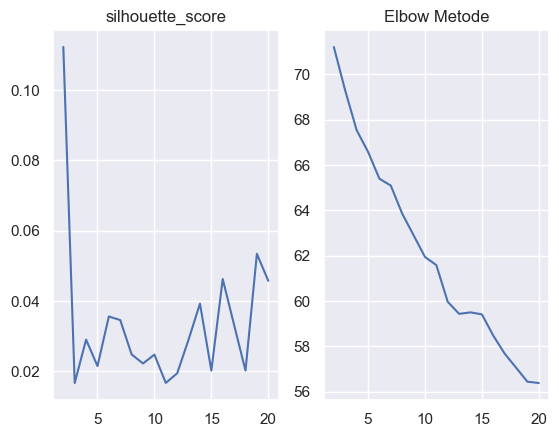

In [ ]:


fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(range(2,kmax+1),sil)
ax2.plot(potential_k, result)
ax1.set_title('silhouette_score')
ax2.set_title('Elbow Metode')
plt.show()


In [ ]:
optimal_k = sil.index(max(sil))+2

In [ ]:
print(f"optimal K using elbow : {optimal_k_elbow}")
print(f"optimal K using silh : {optimal_k}")

optimal K using elbow : 4
optimal K using silh : 2


# Modeling

train the model with the optimal_k value 

In [ ]:
kmeans = KMeans(n_clusters=optimal_k)
y_kmeans = kmeans.fit_predict(data_numeric_standarized)
centers = kmeans.cluster_centers_

# Evaluating

use PCA to reduce the dimentions of the data to plot it in 2d space

In [ ]:
pca_model = PCA(n_components = 2)
pca_model.fit(data_numeric_standarized)

PCA(n_components=2)

In [ ]:
training_data_pca = pca_model.transform(data_numeric_standarized)
centers_pca = pca_model.transform(centers)

c:\Users\nasser\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


draw the data in 2d space

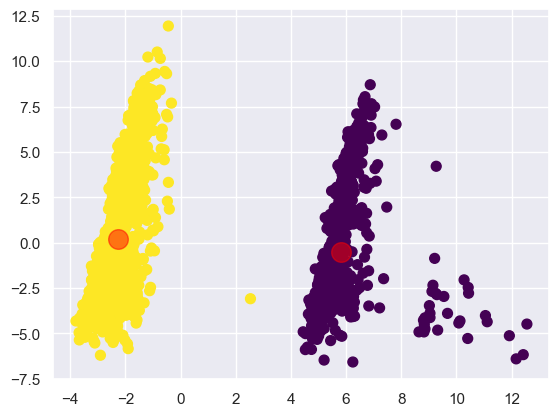

In [ ]:
plt.scatter(training_data_pca[:, 0],
            training_data_pca[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=200, alpha=0.5)

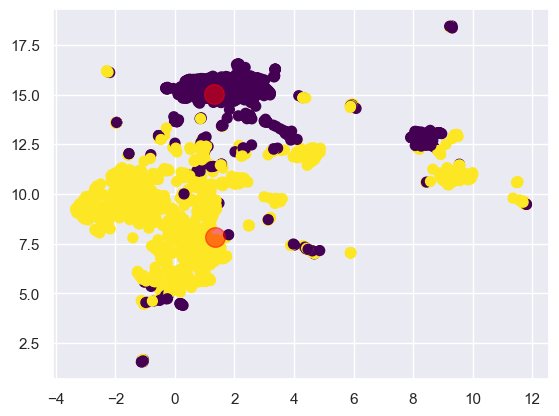

In [ ]:
import umap
reducer = umap.UMAP(n_components=2)
umap_model = reducer.fit(data_numeric_standarized)
training_data_embedding = umap_model.transform(data_numeric_standarized)
centers_embedding = umap_model.transform(centers)

# plot the data in the low dim with the cluster results
plt.scatter(training_data_embedding[:, 0],
            training_data_embedding[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers_embedding[:, 0], centers_embedding[:, 1], c='red', s=200, alpha=0.5);

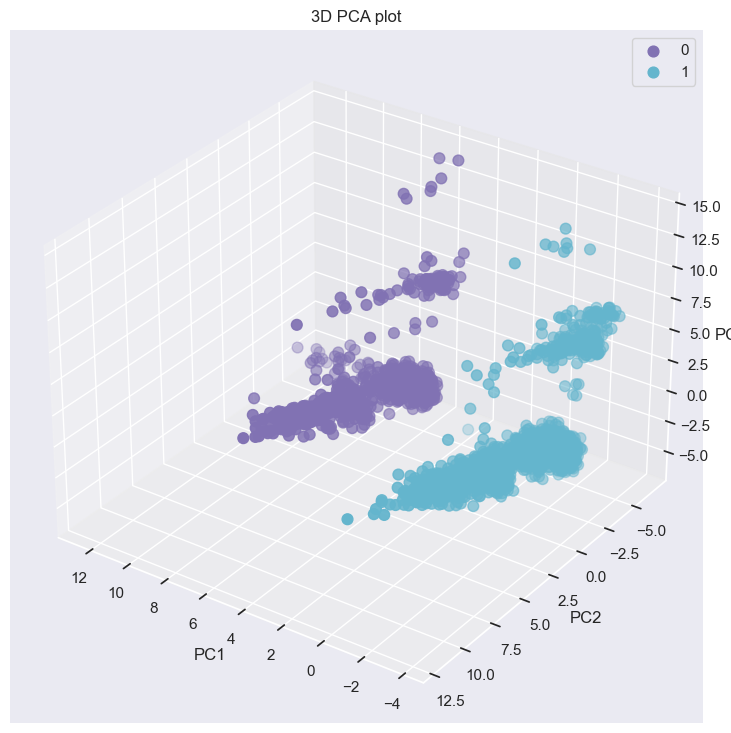

In [ ]:
pca = PCA(n_components=3)
pca.fit(data_numeric_standarized)
pca_bcancer = pca.transform(data_numeric_standarized)
cdict = {0:'m',1:'c',2:'r',3:'y'}
label = {0:'0',1:'1',2:"2",3:"3"}
y = y_kmeans

Xax = pca_bcancer[:,0]
Yax = pca_bcancer[:,1]
Zax = pca_bcancer[:,2]

fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(111, 
                     projection='3d')
 
for l in np.unique(y):
 ix=np.where(y==l)
 ax.scatter(Xax[ix], 
            Yax[ix], 
            Zax[ix], 
            c=cdict[l], 
            s=60,
           label=label[l])
 
ax.set_xlabel("PC1", 
              fontsize=12)
ax.set_ylabel("PC2", 
              fontsize=12)
ax.set_zlabel("PC3", 
              fontsize=12)
 
ax.view_init(30, 125)
ax.legend()
plt.title("3D PCA plot")
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.11224444068394356
For n_clusters = 3 The average silhouette_score is : 0.02224768675771457
For n_clusters = 4 The average silhouette_score is : 0.02894350939522572
For n_clusters = 5 The average silhouette_score is : 0.027851468385545704
For n_clusters = 6 The average silhouette_score is : 0.021925371392559567
For n_clusters = 7 The average silhouette_score is : 0.039079074314931586
For n_clusters = 8 The average silhouette_score is : 0.028116523065653043
For n_clusters = 9 The average silhouette_score is : 0.027194949585715156


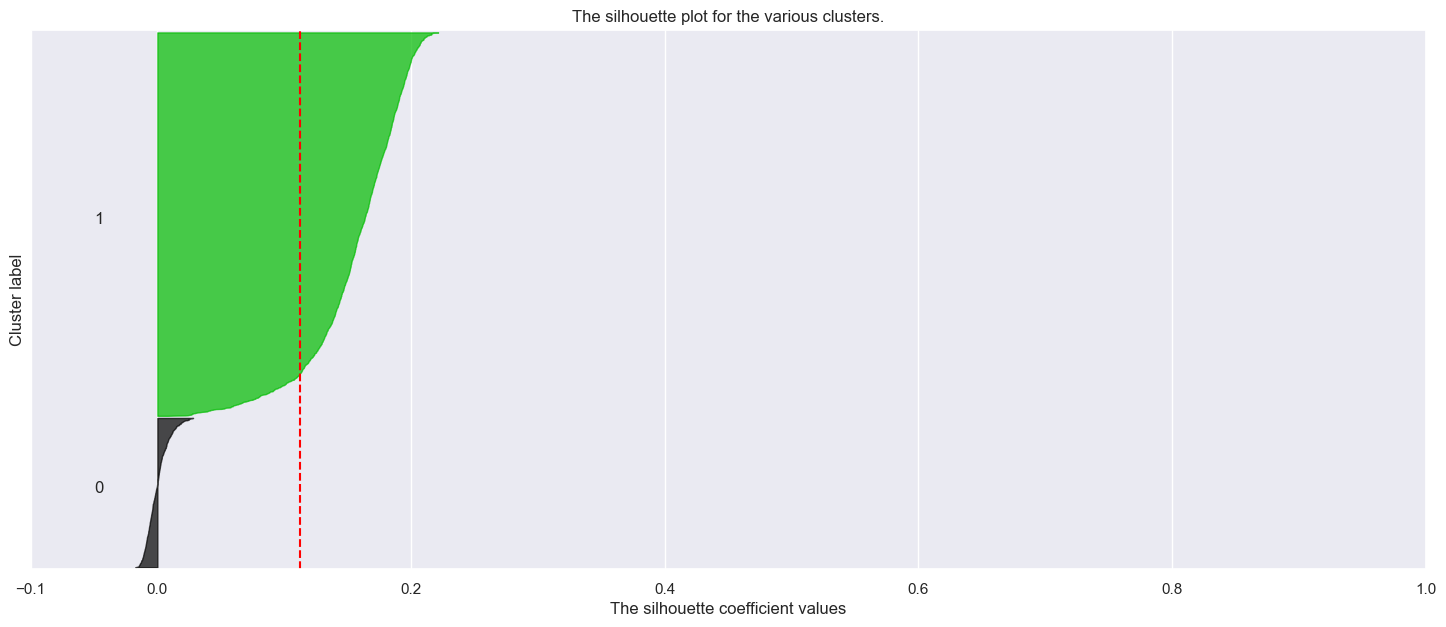

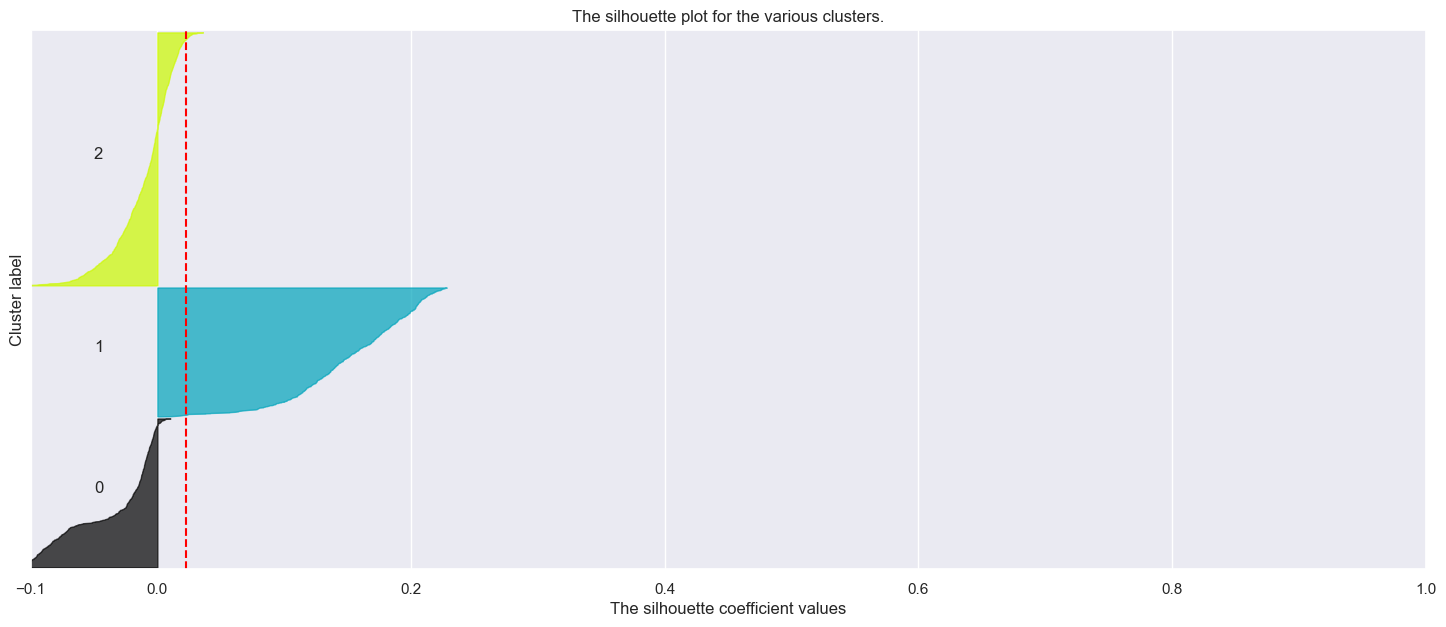

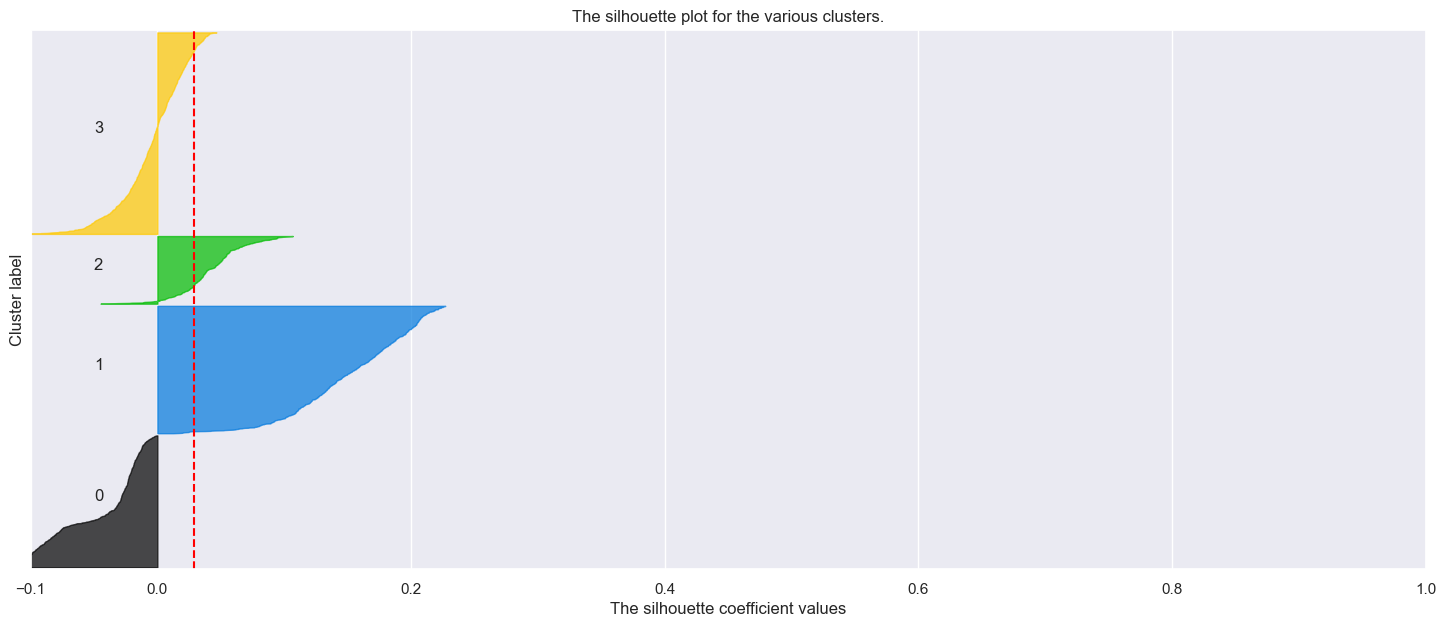

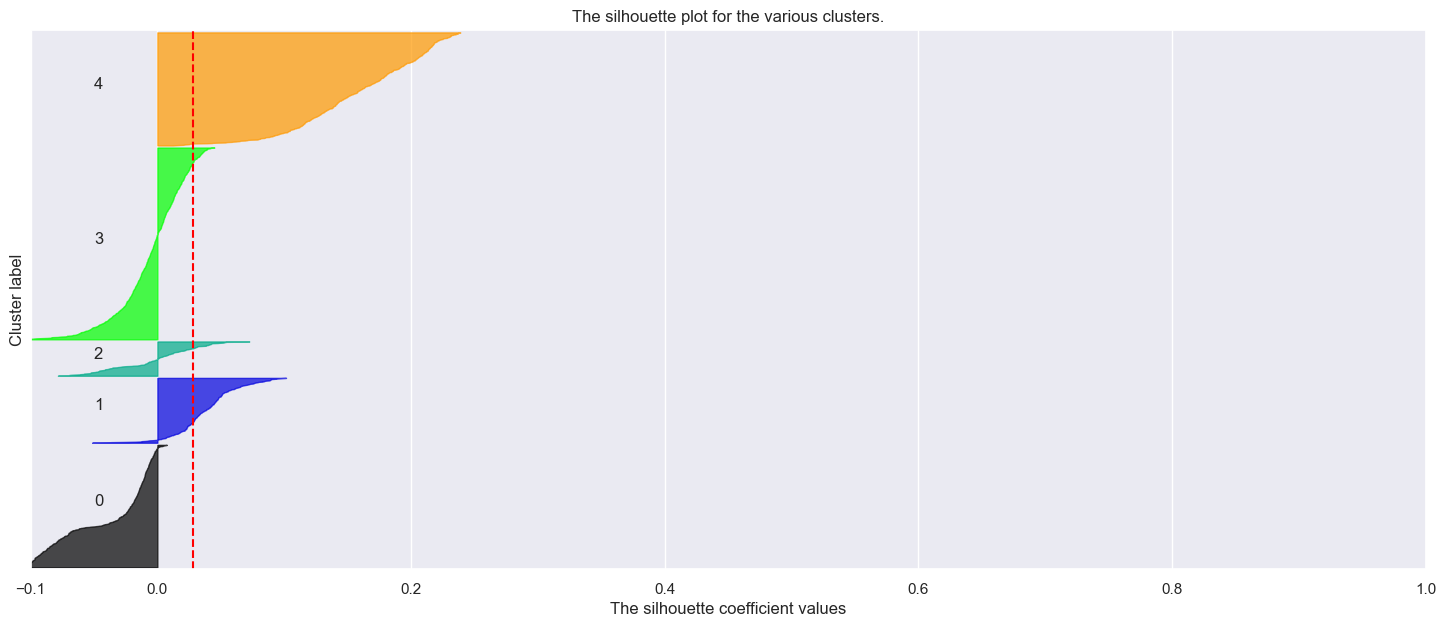

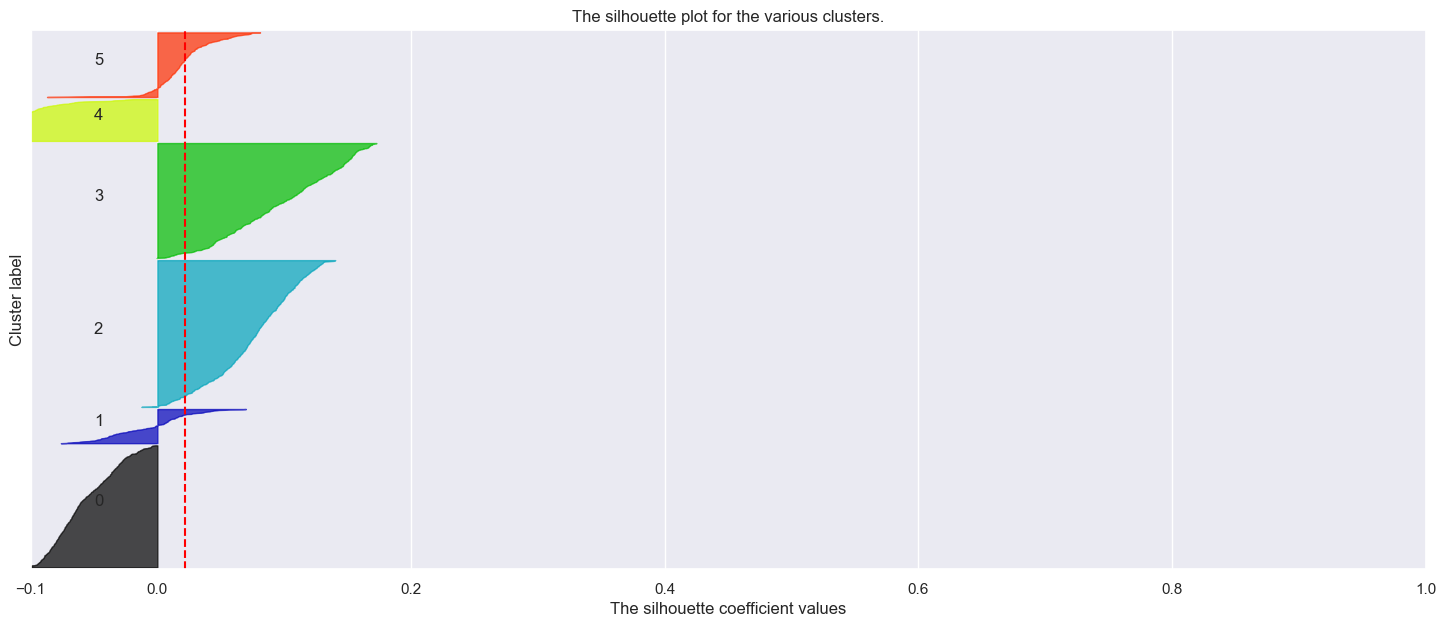

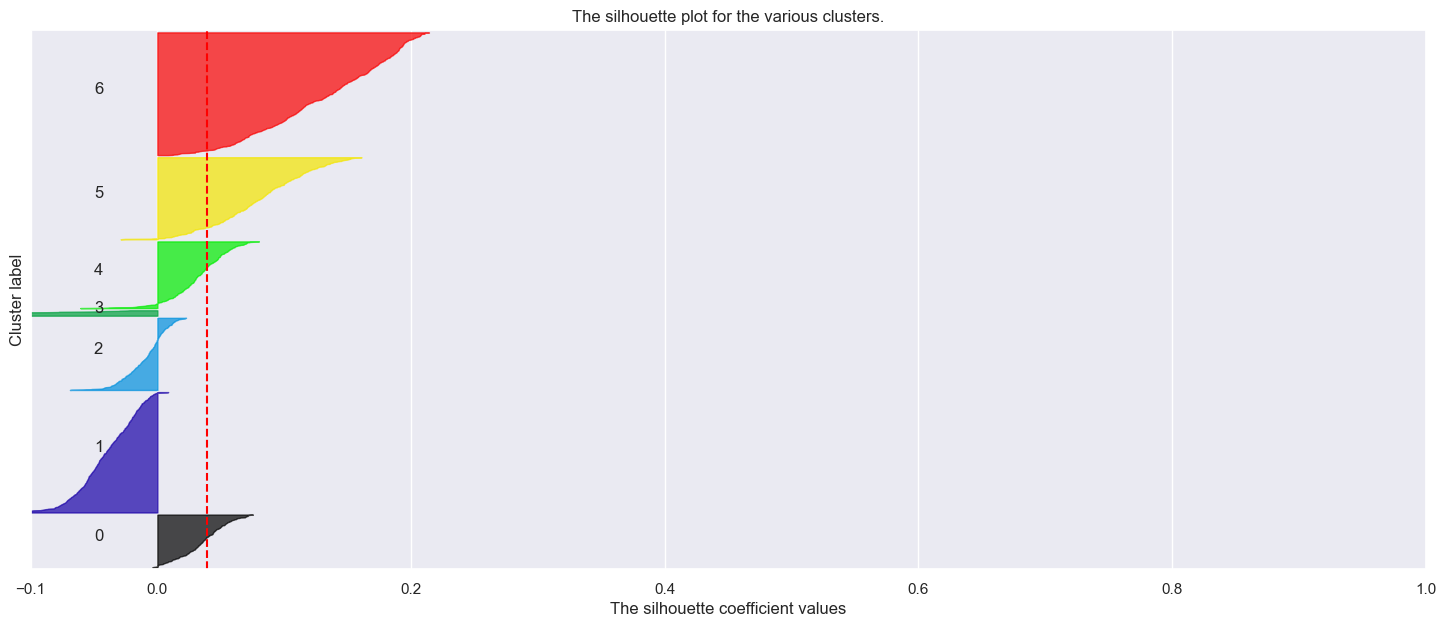

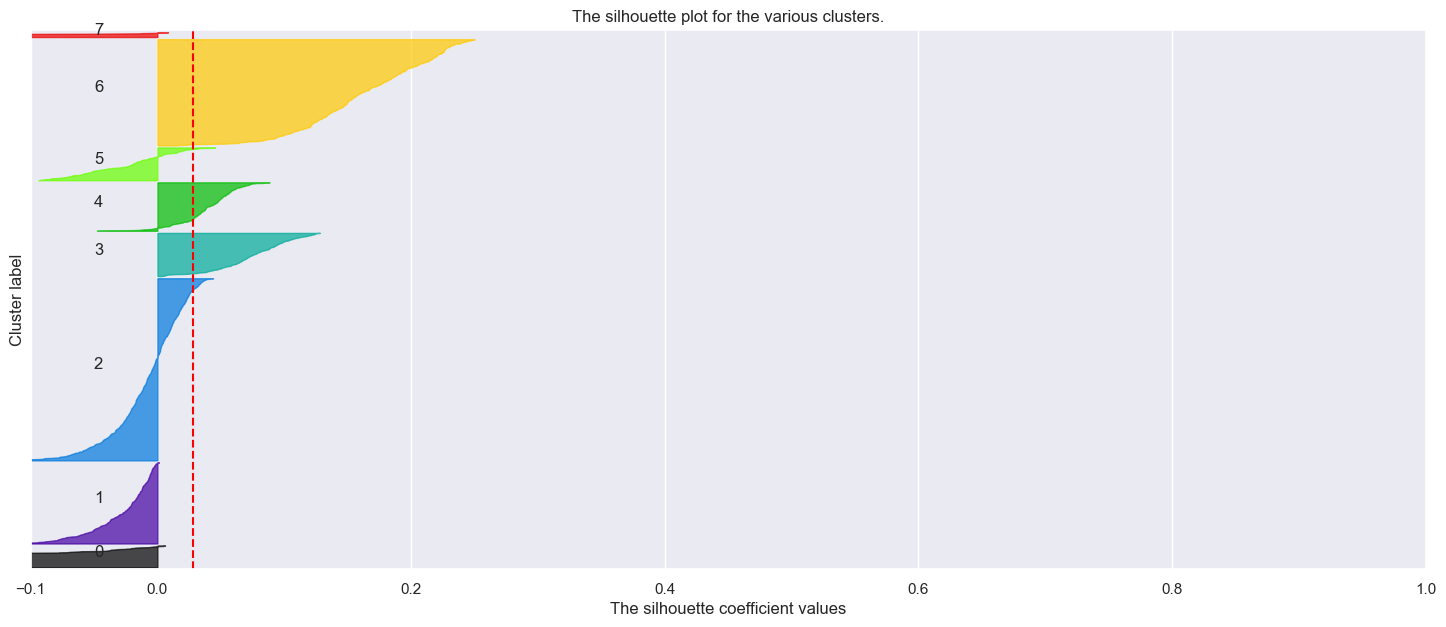

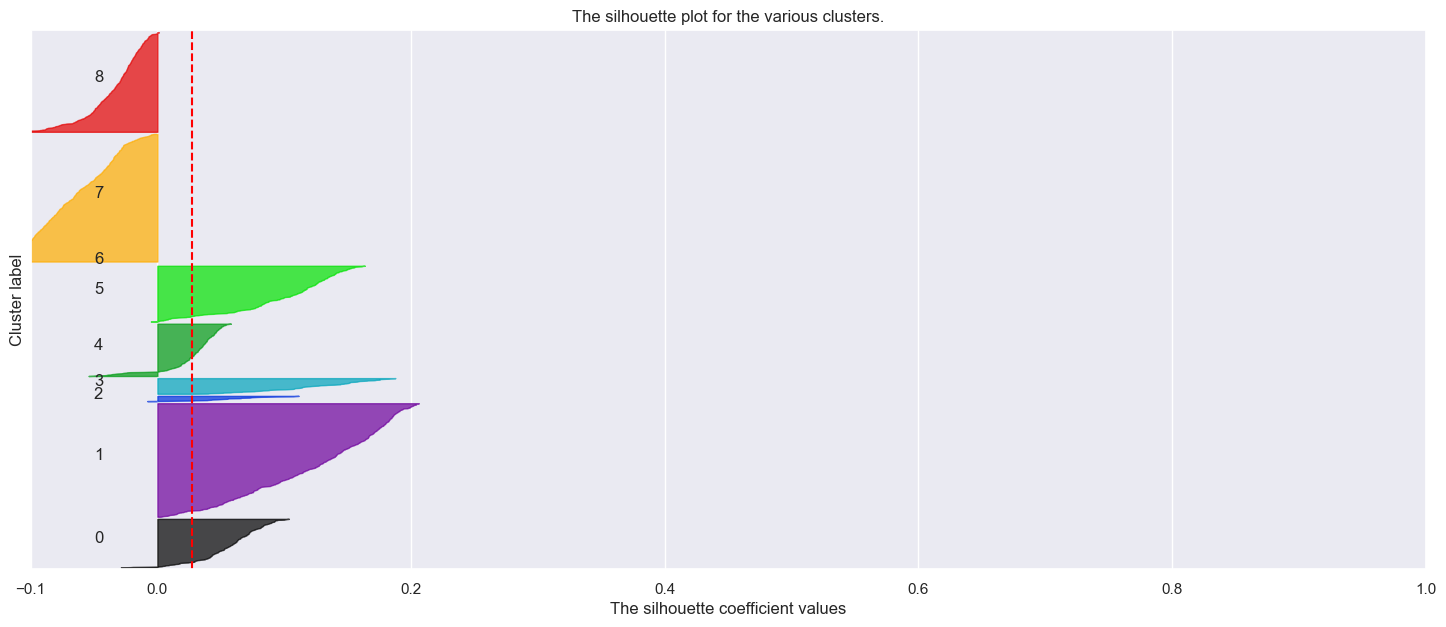

In [ ]:
potential_k = list(range(2, 10))
for n_clusters in potential_k:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data_numeric_standarized) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(data_numeric_standarized)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data_numeric_standarized, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data_numeric_standarized, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [ ]:
import umap
reducer = umap.UMAP(n_components=2)
umap_model = reducer.fit(data_numeric_standarized)

In [ ]:
training_data_embedding = umap_model.transform(data_numeric_standarized)
centers_embedding = umap_model.transform(centers)

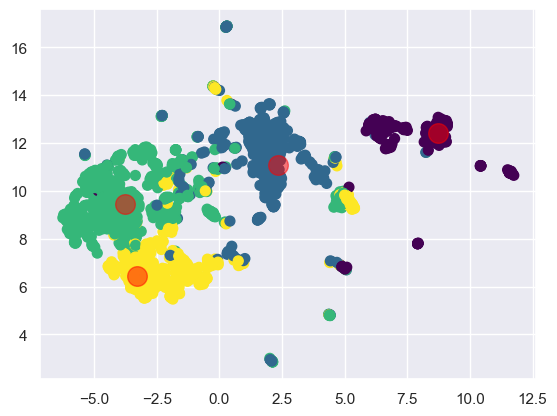